<a href="https://colab.research.google.com/github/shailshree23/SmartPlantCare/blob/main/Smart_Room_Plant_Care_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Synthetic Dataset Generation for "Smart Room Plant Care Advisor"**

In [ ]:
import pandas as pd
import numpy as np

# --- Configuration ---
NUM_ROWS = 650 # Let's aim for 650 rows

PLANT_TYPES_PROPS = {
    "Succulent": {
        "ideal_sun": (5, 8), "ideal_water_freq": (0.25, 1), "base_growth_potential": 0.2,
        "water_sensitivity_high": 0.8, "water_sensitivity_low": 0.3 # Penalty for too much/little
    },
    "Fern": {
        "ideal_sun": (2, 5), "ideal_water_freq": (2, 4), "base_growth_potential": 0.5,
        "water_sensitivity_high": 0.4, "water_sensitivity_low": 0.6
    },
    "Flowering_Annual": {
        "ideal_sun": (4, 7), "ideal_water_freq": (3, 5), "base_growth_potential": 0.8,
        "water_sensitivity_high": 0.5, "water_sensitivity_low": 0.5
    },
    "Cactus": {
        "ideal_sun": (6, 8), "ideal_water_freq": (0.1, 0.5), "base_growth_potential": 0.1,
        "water_sensitivity_high": 0.9, "water_sensitivity_low": 0.2
    },
    "Leafy_Green": {
        "ideal_sun": (3, 6), "ideal_water_freq": (1.5, 3), "base_growth_potential": 0.6,
        "water_sensitivity_high": 0.4, "water_sensitivity_low": 0.4
    }
}
PLANT_TYPE_NAMES = list(PLANT_TYPES_PROPS.keys())

LEAF_APPEARANCES = ['Healthy', 'Yellowing', 'Brown_Spots', 'Wilting', 'Pest_Damage', 'Slightly_Pale']

# --- Data Generation ---
data = []

for i in range(NUM_ROWS):
    plant_id = i + 1
    plant_type_name = np.random.choice(PLANT_TYPE_NAMES, p=[0.25, 0.2, 0.2, 0.15, 0.2]) # Probabilities for each type
    props = PLANT_TYPES_PROPS[plant_type_name]

    # --- Base Care Inputs ---
    # Sunlight: Some randomness, but try to bias towards ideal for type
    sun_deviation = np.random.normal(0, 1.5) # How much it deviates from ideal midpoint
    sunlight_hours = np.clip( (props["ideal_sun"][0] + props["ideal_sun"][1])/2 + sun_deviation, 0, 10)

    # Watering: Similar logic
    water_deviation = np.random.normal(0, 0.8)
    watering_freq = np.clip( (props["ideal_water_freq"][0] + props["ideal_water_freq"][1])/2 + water_deviation, 0.1, 7)

    room_temp_c = np.random.uniform(17, 28)
    fertilizer_used = np.random.choice([0, 1], p=[0.7, 0.3]) # 0:No, 1:Yes
    initial_plant_height_cm = np.random.uniform(5, 40)

    # --- Simulated Observable Conditions (influenced by care & plant type) ---
    observed_pests = np.random.choice([0, 1], p=[0.9, 0.1]) # Small chance of pests

    # Soil Moisture: Higher if watered more, lower if less. Scale 1-10
    # Basic heuristic: More frequent watering = higher moisture. Cacti/Succulents dry out faster.
    soil_moisture = np.clip(watering_freq * 1.5 - (1 if plant_type_name in ["Cactus", "Succulent"] else 0) + np.random.normal(0,1), 1, 10)

    # Leaf Appearance: Complex rules needed here for realism
    # Simplified logic for now:
    leaf_appearance = 'Healthy'
    risk_score_for_leaves = 0 # internal score to help determine leaf appearance and risk

    # Penalize for bad watering
    if watering_freq > props["ideal_water_freq"][1] * 1.5: # Overwatered
        risk_score_for_leaves += props["water_sensitivity_high"] * 2
        if plant_type_name in ["Succulent", "Cactus"]: risk_score_for_leaves += 1 # extra penalty
    elif watering_freq < props["ideal_water_freq"][0] * 0.7: # Underwatered
        risk_score_for_leaves += props["water_sensitivity_low"] * 2

    # Penalize for bad sunlight (very simple)
    if sunlight_hours < props["ideal_sun"][0] * 0.8 or sunlight_hours > props["ideal_sun"][1] * 1.2:
        risk_score_for_leaves += 0.5

    if observed_pests == 1:
        risk_score_for_leaves += 2.5

    # Determine Leaf Appearance based on risk_score_for_leaves
    if risk_score_for_leaves > 3.5:
        leaf_appearance = np.random.choice(['Pest_Damage', 'Wilting', 'Brown_Spots'] if observed_pests else ['Wilting', 'Brown_Spots','Yellowing'])
    elif risk_score_for_leaves > 2.0:
        leaf_appearance = np.random.choice(['Yellowing', 'Brown_Spots', 'Slightly_Pale'])
    elif risk_score_for_leaves > 0.5:
        leaf_appearance = 'Slightly_Pale'
    else: # Low risk score means healthy or very minor issues
        leaf_appearance = 'Healthy'
    if observed_pests and leaf_appearance == 'Healthy': # pests should cause some visible damage
         leaf_appearance = np.random.choice(['Pest_Damage', 'Slightly_Pale'])


    # --- Target 1: Actual_Growth_In_1_Month_cm (Linear Regression) ---
    # Start with base growth potential, adjust by care.
    growth_factor = props["base_growth_potential"]

    # Sun impact
    if props["ideal_sun"][0] <= sunlight_hours <= props["ideal_sun"][1]:
        growth_factor += 0.2 # Bonus for ideal sun
    else:
        growth_factor -= 0.1 * abs(sunlight_hours - (props["ideal_sun"][0] + props["ideal_sun"][1])/2 ) # Penalty for non-ideal

    # Water impact
    if props["ideal_water_freq"][0] <= watering_freq <= props["ideal_water_freq"][1]:
        growth_factor += 0.15
    elif watering_freq > props["ideal_water_freq"][1]: # Overwater
        growth_factor -= props["water_sensitivity_high"] * (watering_freq - props["ideal_water_freq"][1]) * 0.2
    else: # Underwater
        growth_factor -= props["water_sensitivity_low"] * (props["ideal_water_freq"][0] - watering_freq) * 0.2

    if fertilizer_used == 1 and plant_type_name != "Cactus": # Cacti usually don't need much fertilizer
        growth_factor += 0.3
    if observed_pests == 1:
        growth_factor -= 0.4
    if leaf_appearance not in ['Healthy', 'Slightly_Pale']:
        growth_factor -= 0.2 # General penalty for bad leaves

    # Growth relative to current height + absolute base growth
    # More established plants might grow more in absolute terms, or less if they reached max size
    # Simple model: proportional growth + small base growth
    actual_growth_cm = initial_plant_height_cm * np.clip(growth_factor * 0.1, -0.05, 0.15) + np.random.normal(props["base_growth_potential"], 0.1)
    actual_growth_cm = np.clip(actual_growth_cm, 0, 15) # Max 15cm growth/month, min 0
    if plant_type_name == "Cactus" or plant_type_name == "Succulent": # Slower growers
        actual_growth_cm = np.clip(actual_growth_cm, 0, 5)


    # --- Target 2: Risk_Category (Linear Classification) ---
    risk_category = "Low"
    final_risk_points = 0

    if observed_pests == 1: final_risk_points += 3
    if leaf_appearance == 'Wilting': final_risk_points += 2.5
    elif leaf_appearance == 'Pest_Damage': final_risk_points += 2
    elif leaf_appearance in ['Yellowing', 'Brown_Spots']: final_risk_points += 1.5
    elif leaf_appearance == 'Slightly_Pale': final_risk_points += 0.5

    # Add risk from extremely bad conditions not yet reflected in leaves
    if soil_moisture < 2 and plant_type_name not in ["Cactus", "Succulent"]: final_risk_points += 1 # Very dry
    if soil_moisture > 8.5 and plant_type_name in ["Cactus", "Succulent"]: final_risk_points += 1.5 # Very wet for dry plants

    if sunlight_hours < props["ideal_sun"][0]*0.5 or sunlight_hours > props["ideal_sun"][1]*1.5: # Way off sunlight
        final_risk_points +=1

    if final_risk_points >= 3.5:
        risk_category = "High_Risk_Immediate_Attention"
    elif final_risk_points >= 1.5:
        risk_category = "Moderate_Risk_Needs_Monitoring"
    else:
        risk_category = "Low_Risk"


    data.append([
        plant_id, plant_type_name, sunlight_hours, watering_freq, room_temp_c,
        fertilizer_used, soil_moisture, leaf_appearance, observed_pests,
        initial_plant_height_cm, actual_growth_cm, risk_category
    ])

# --- Create DataFrame ---
df = pd.DataFrame(data, columns=[
    "Plant_ID", "Plant_Type", "Sunlight_Hours_Per_Day", "Watering_Frequency_Per_Week",
    "Room_Temperature_C", "Fertilizer_Used", "Soil_Moisture_Reading",
    "Leaf_Appearance", "Observed_Pests", "Initial_Plant_Height_cm",
    "Actual_Growth_In_1_Month_cm", "Risk_Category"
])

# Display some info and head
print(f"Generated {len(df)} rows.")
print("\nDataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nTarget Value Counts for Risk_Category:")
print(df['Risk_Category'].value_counts(normalize=True))
print("\nBasic Stats for Growth:")
print(df['Actual_Growth_In_1_Month_cm'].describe())
print("\nExample of records per plant type:")
print(df['Plant_Type'].value_counts())


df.to_csv("synthetic_plant_care_dataset.csv", index=False)

Generated 650 rows.

Dataset Head:
   Plant_ID        Plant_Type  Sunlight_Hours_Per_Day  \
0         1            Cactus                7.784278   
1         2  Flowering_Annual                4.214237   
2         3            Cactus                8.760338   
3         4              Fern                2.760385   
4         5              Fern                4.531132   

   Watering_Frequency_Per_Week  Room_Temperature_C  Fertilizer_Used  \
0                     0.100000           26.980238                1   
1                     3.661461           25.442355                0   
2                     0.955894           17.018576                1   
3                     3.885771           19.698854                1   
4                     3.520488           19.054262                0   

   Soil_Moisture_Reading Leaf_Appearance  Observed_Pests  \
0               1.000000         Healthy               0   
1               5.091760         Healthy               0   
2              

**Exploratory Data Analysis (EDA)**

--- Basic Info & Descriptive Stats ---

Numerical Features Description:
        Plant_ID  Sunlight_Hours_Per_Day  Watering_Frequency_Per_Week  \
count  650.00000              650.000000                   650.000000   
mean   325.50000                5.528210                     2.005443   
std    187.78312                1.949902                     1.519208   
min      1.00000                0.000000                     0.100000   
25%    163.25000                4.113339                     0.571019   
50%    325.50000                5.564733                     1.818994   
75%    487.75000                6.913466                     3.226505   
max    650.00000               10.000000                     6.590542   

       Room_Temperature_C  Fertilizer_Used  Soil_Moisture_Reading  \
count          650.000000       650.000000             650.000000   
mean            22.503557         0.287692               3.172372   
std              3.261009         0.453036               2.3012

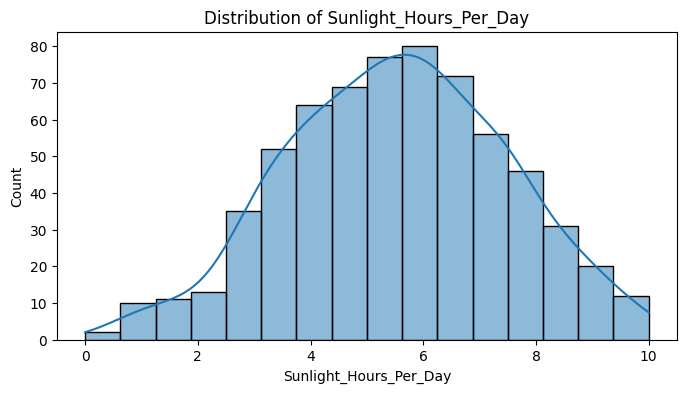

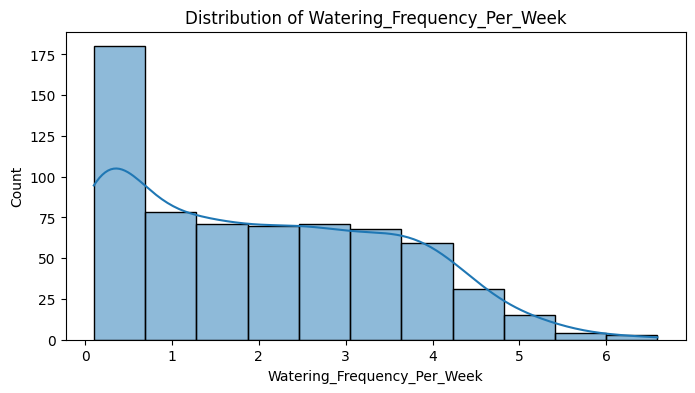

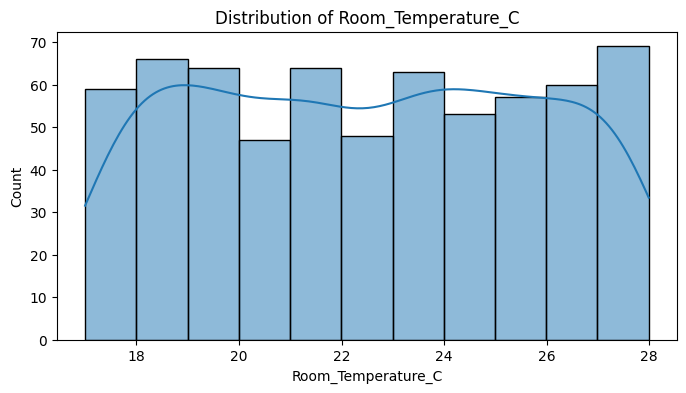

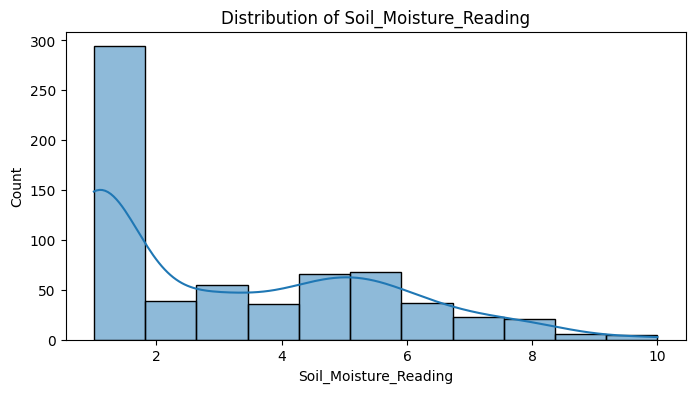

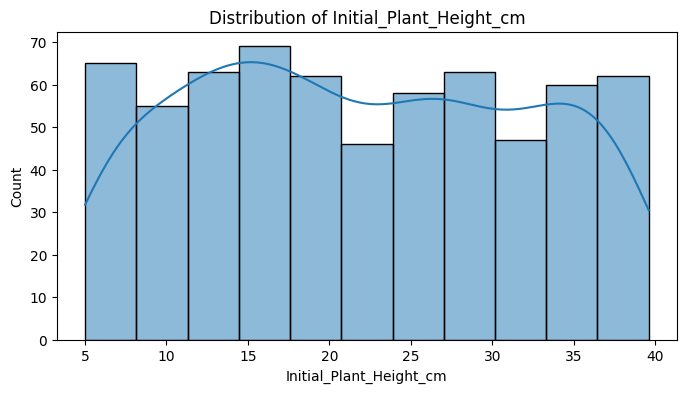

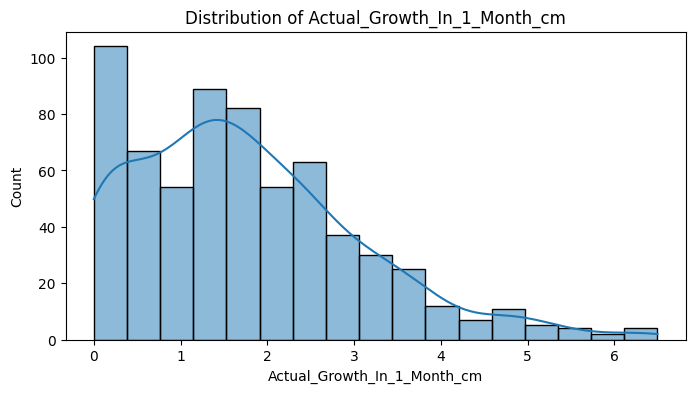


--- Distribution of Categorical Features ---


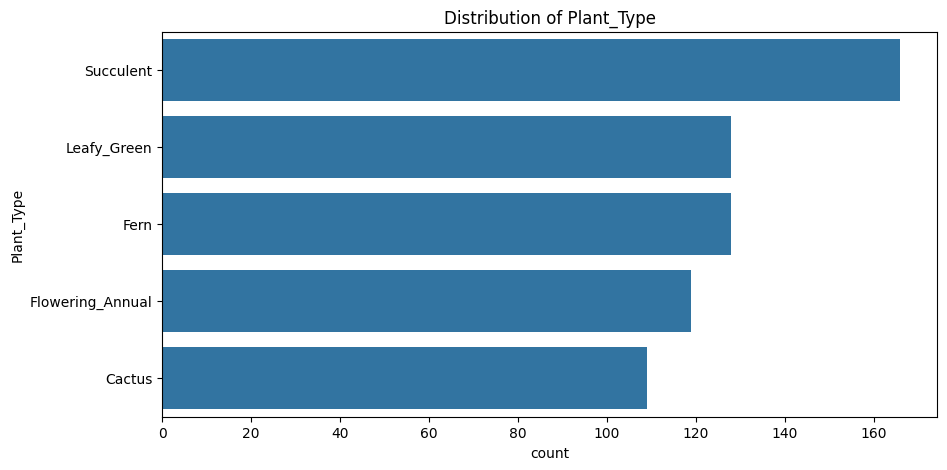

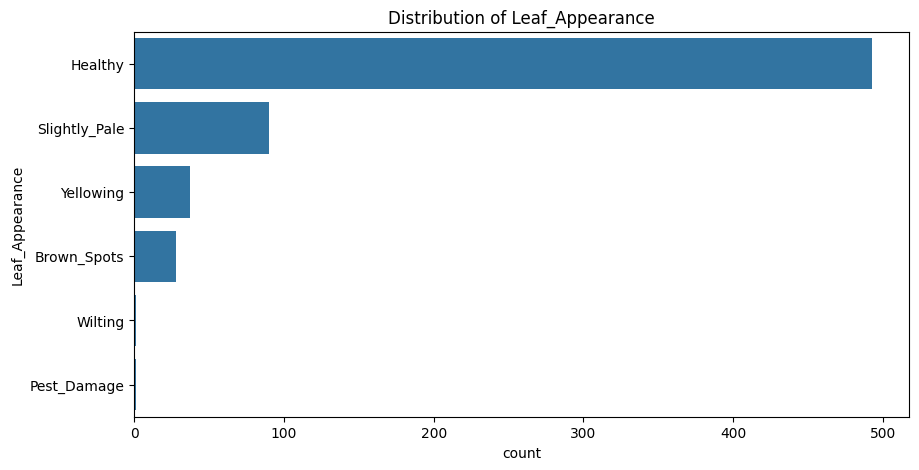

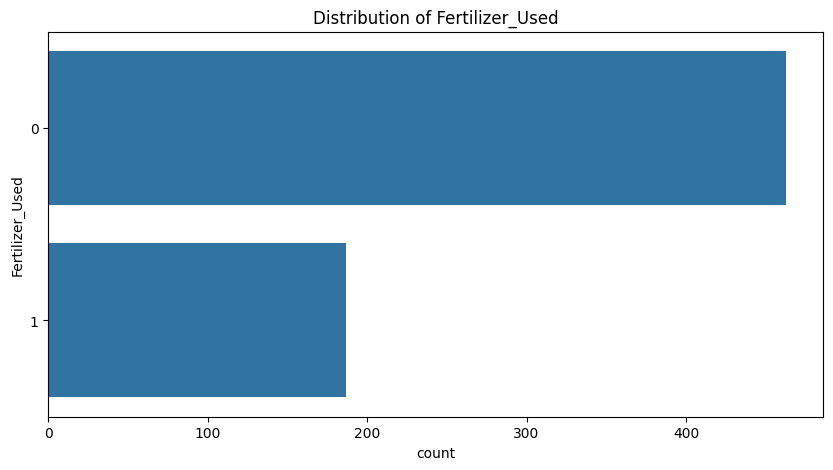

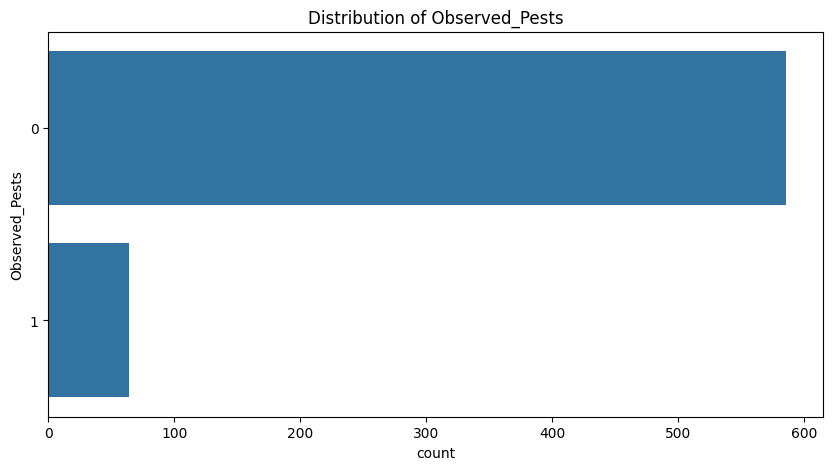

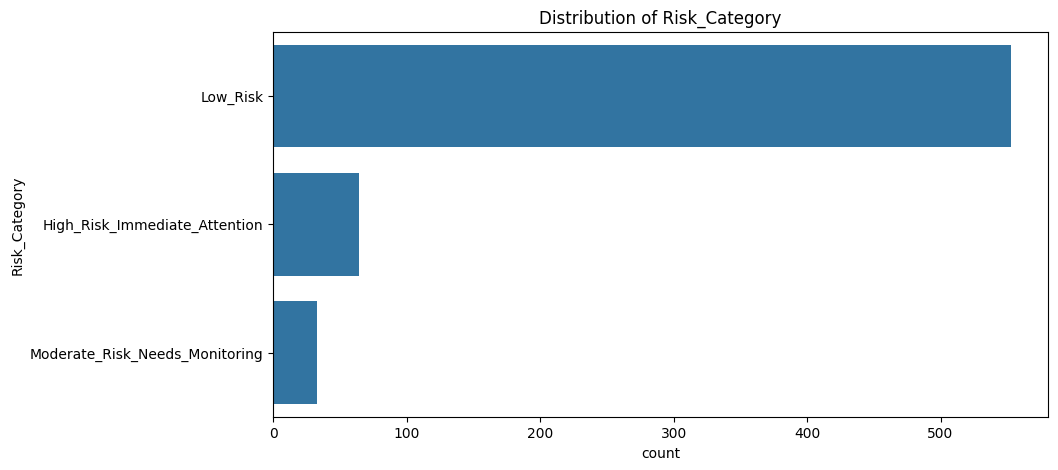


--- Relationships: Numerical Features vs. Regression Target (Actual_Growth_In_1_Month_cm) ---


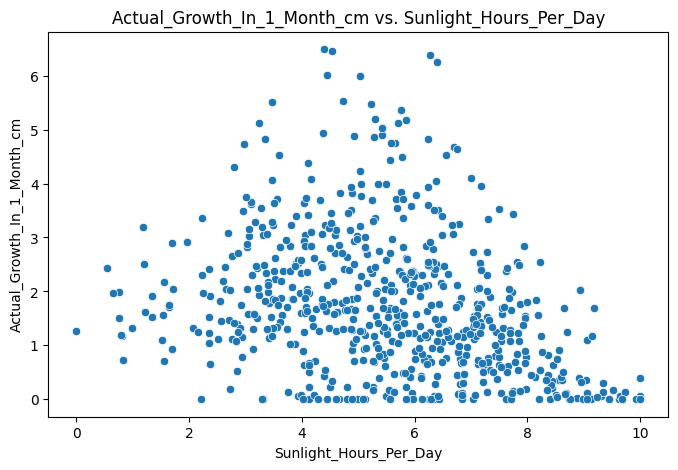

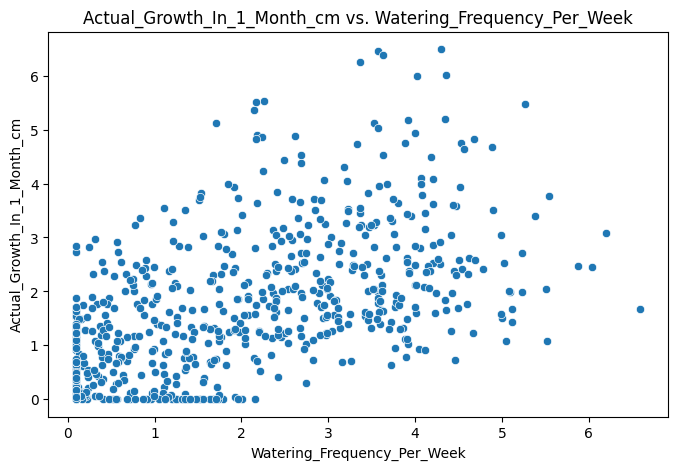

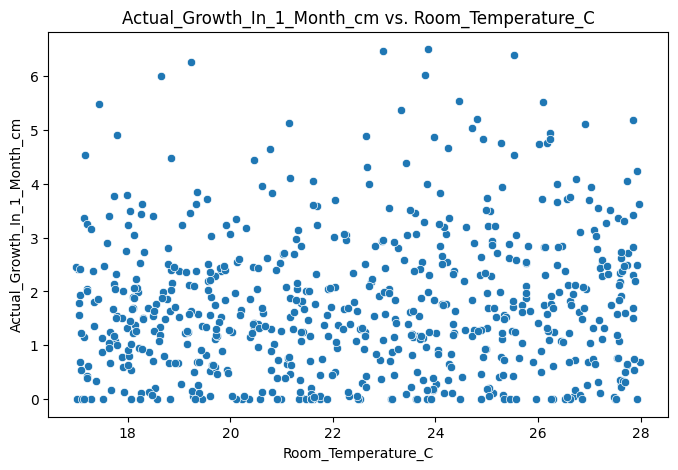

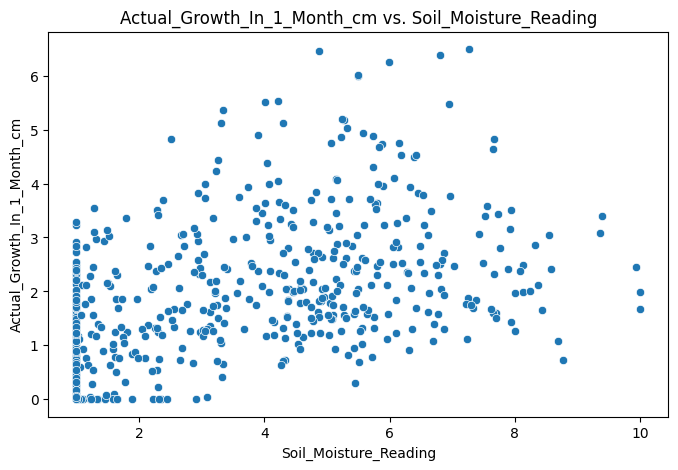

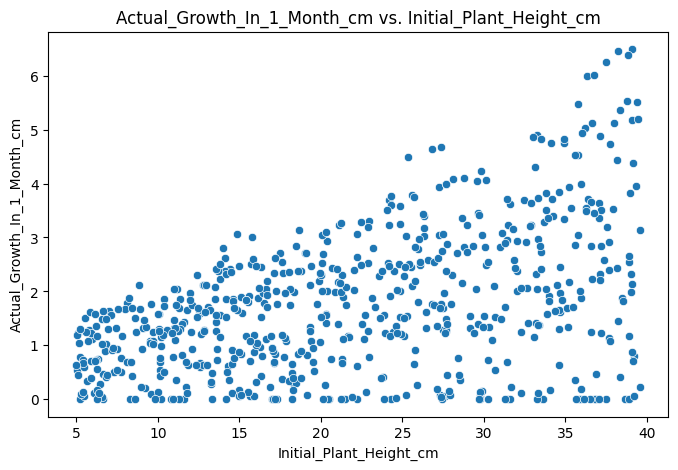


--- Relationships: Categorical Features vs. Regression Target (Actual_Growth_In_1_Month_cm) ---


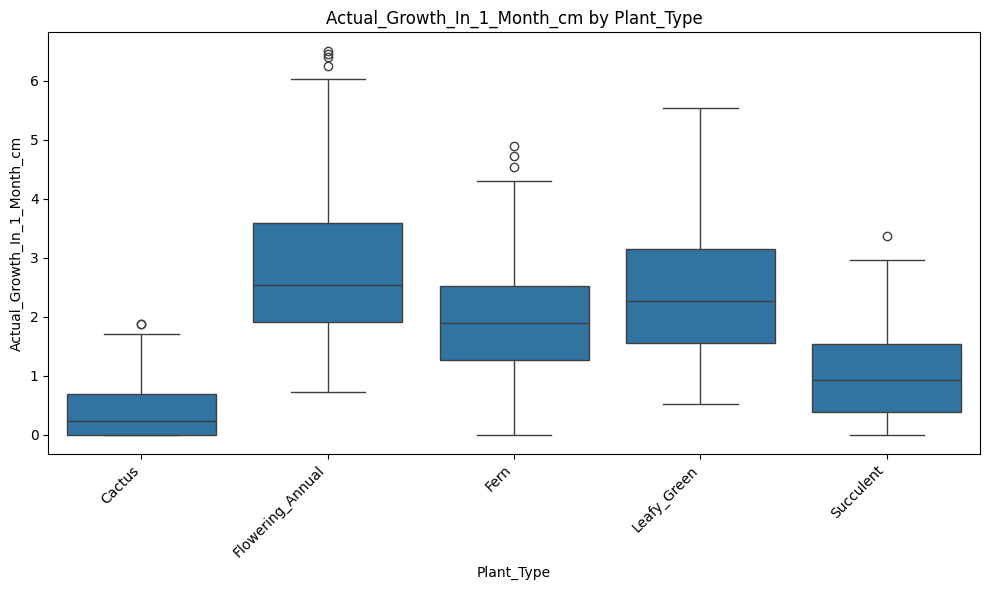

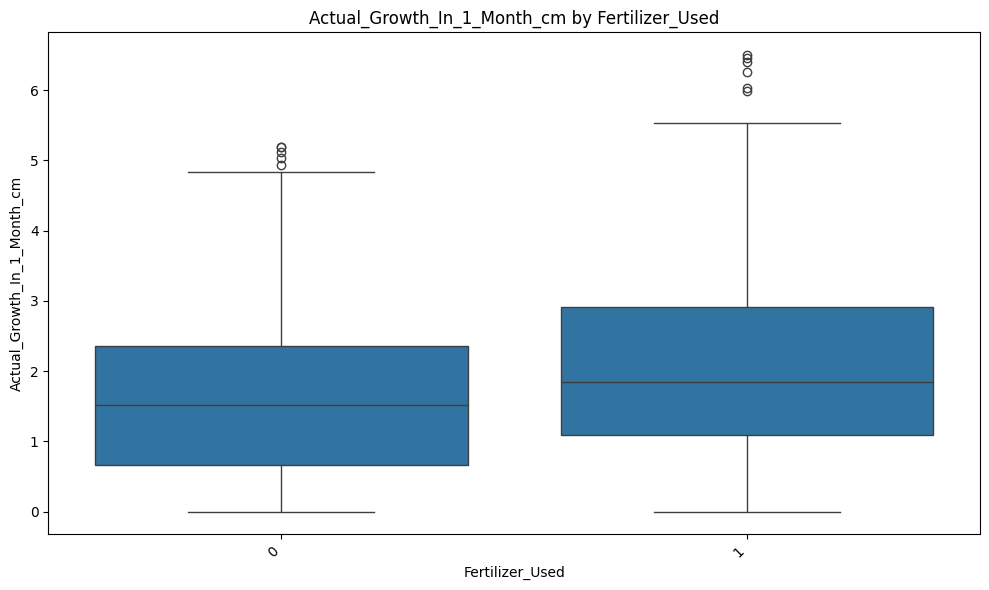

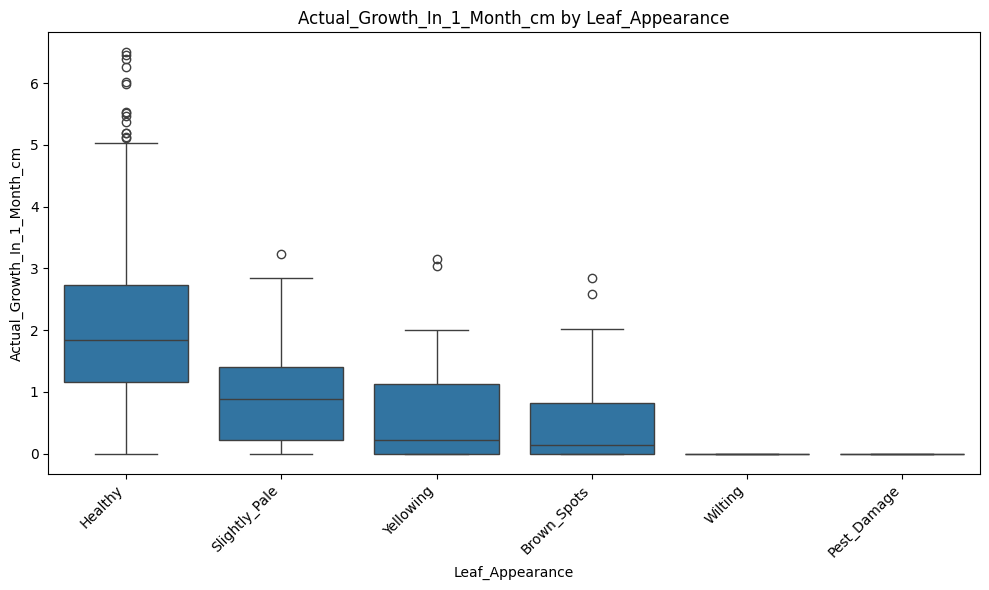


--- Relationships: Numerical Features vs. Classification Target (Risk_Category) ---


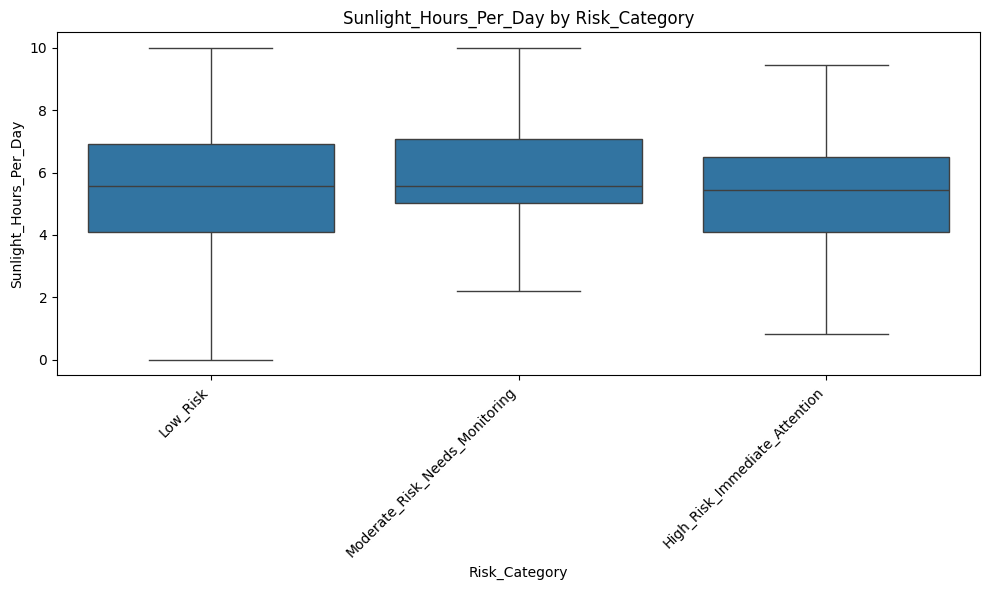

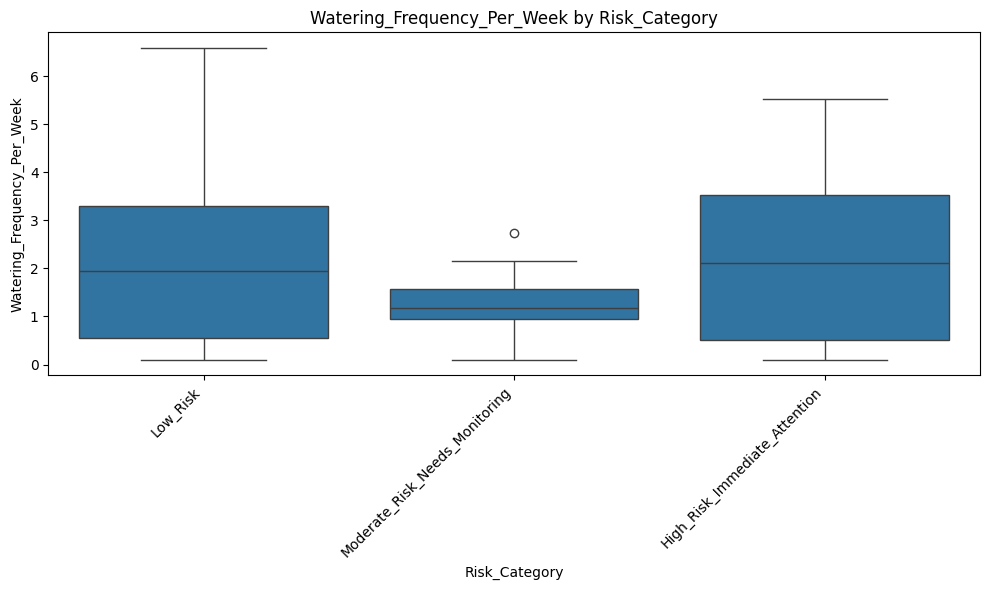

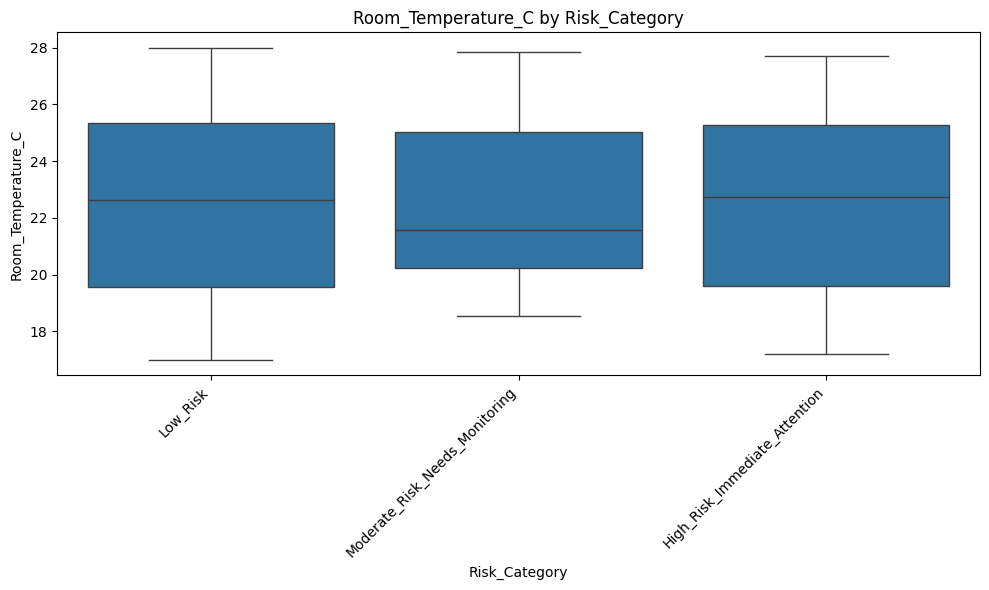

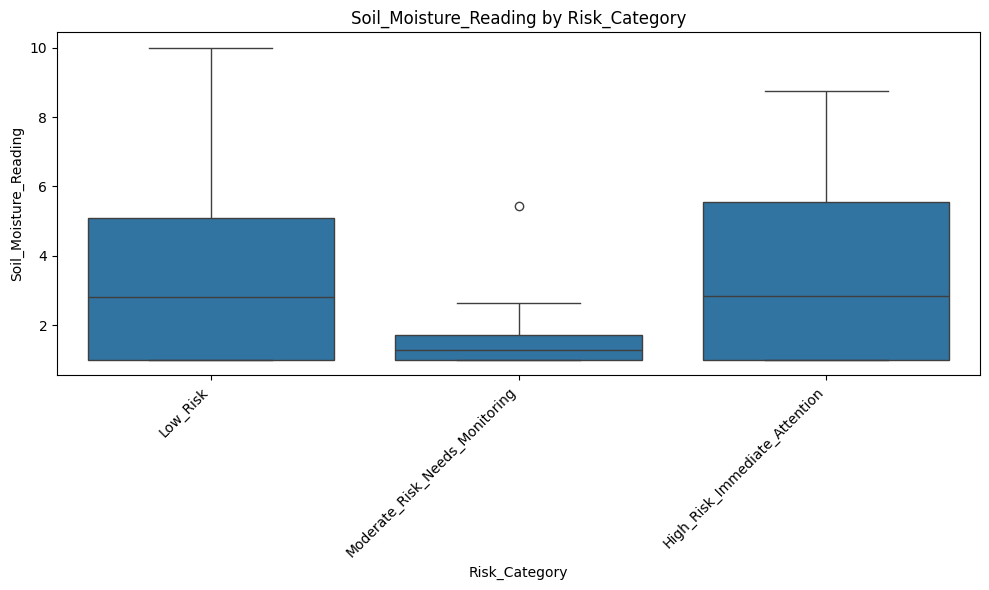

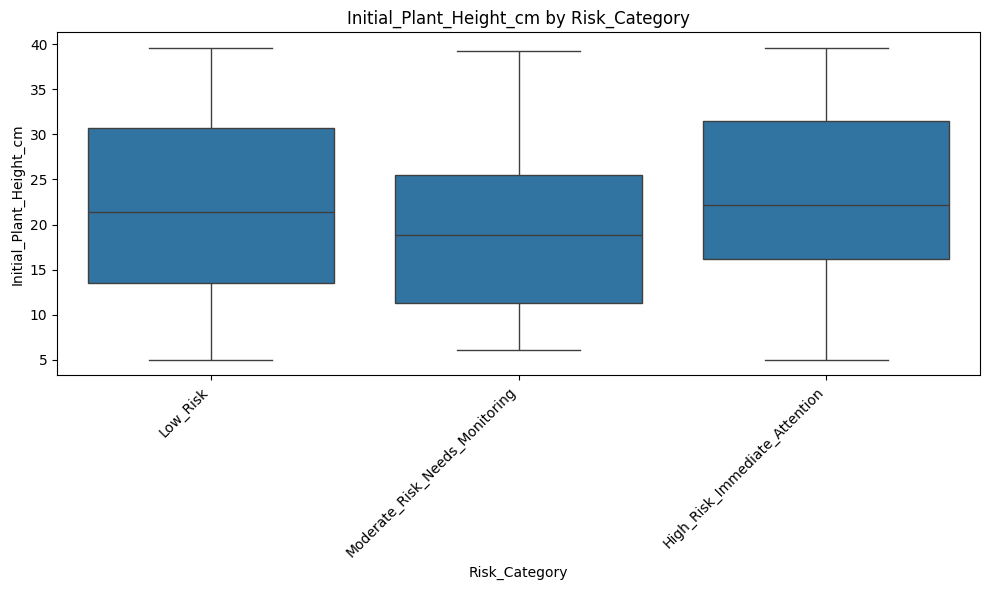


--- Relationships: Categorical Features vs. Classification Target (Risk_Category) ---


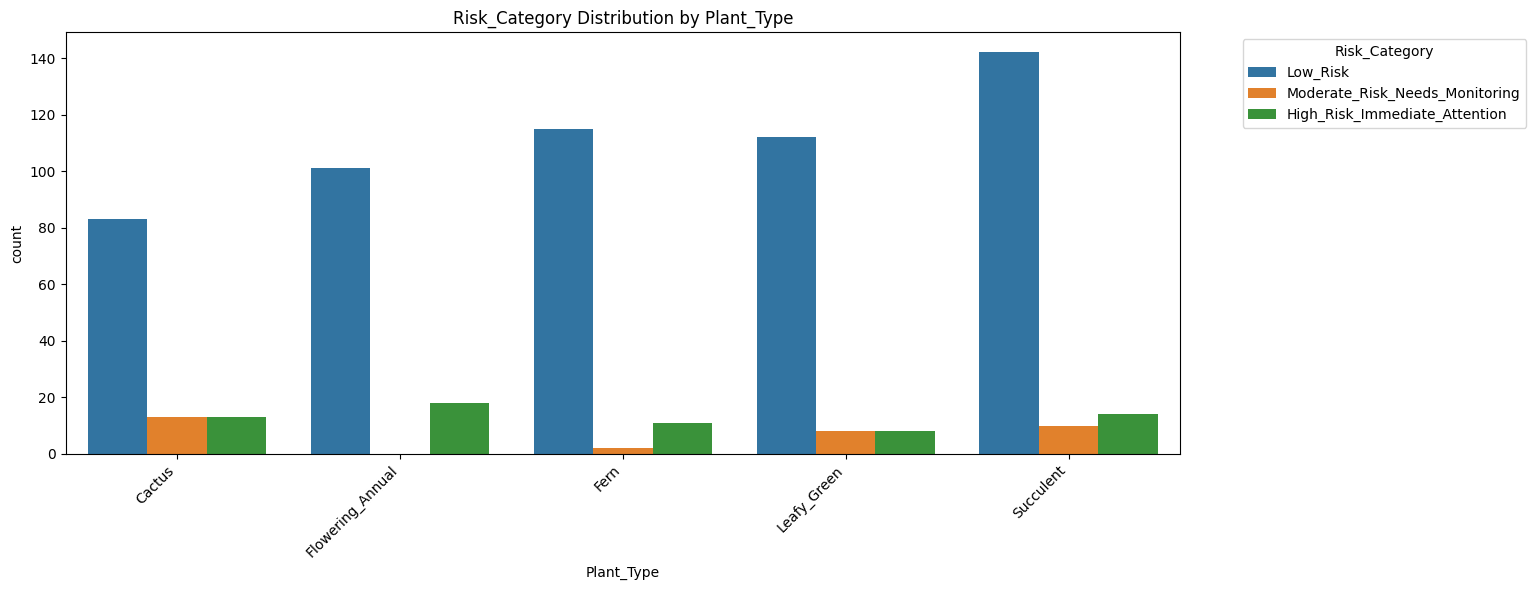

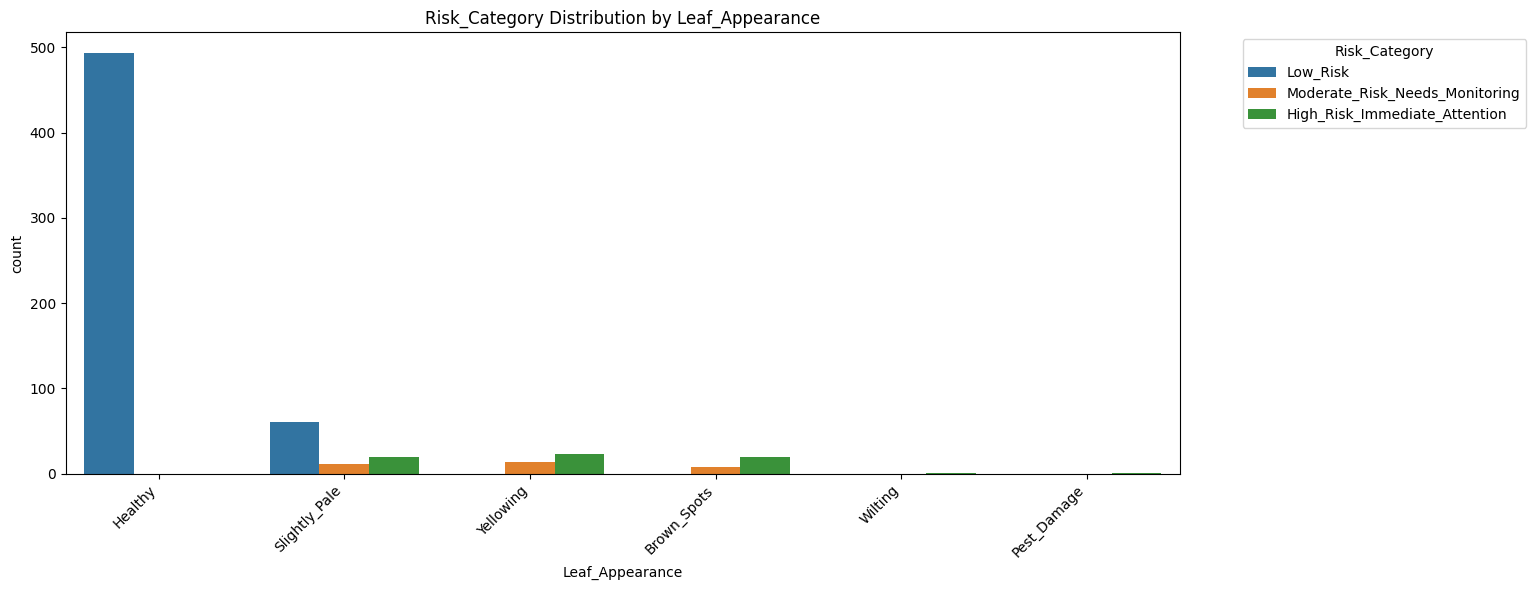

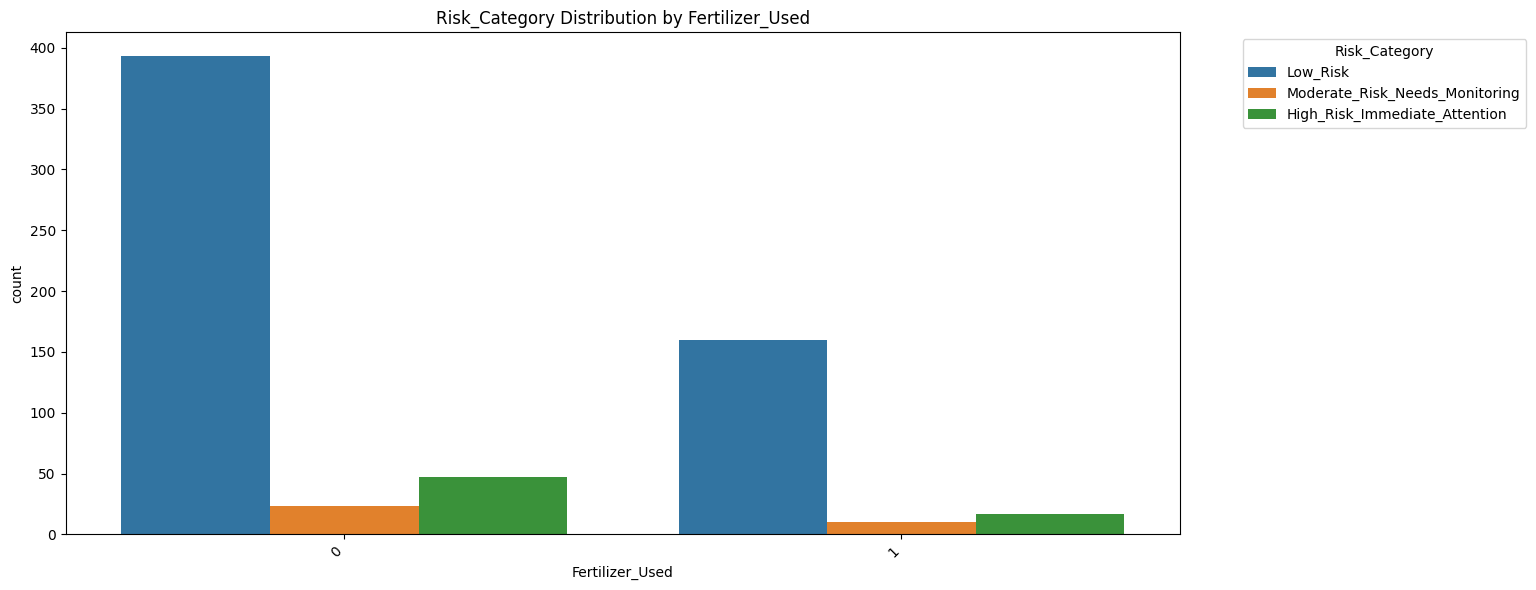

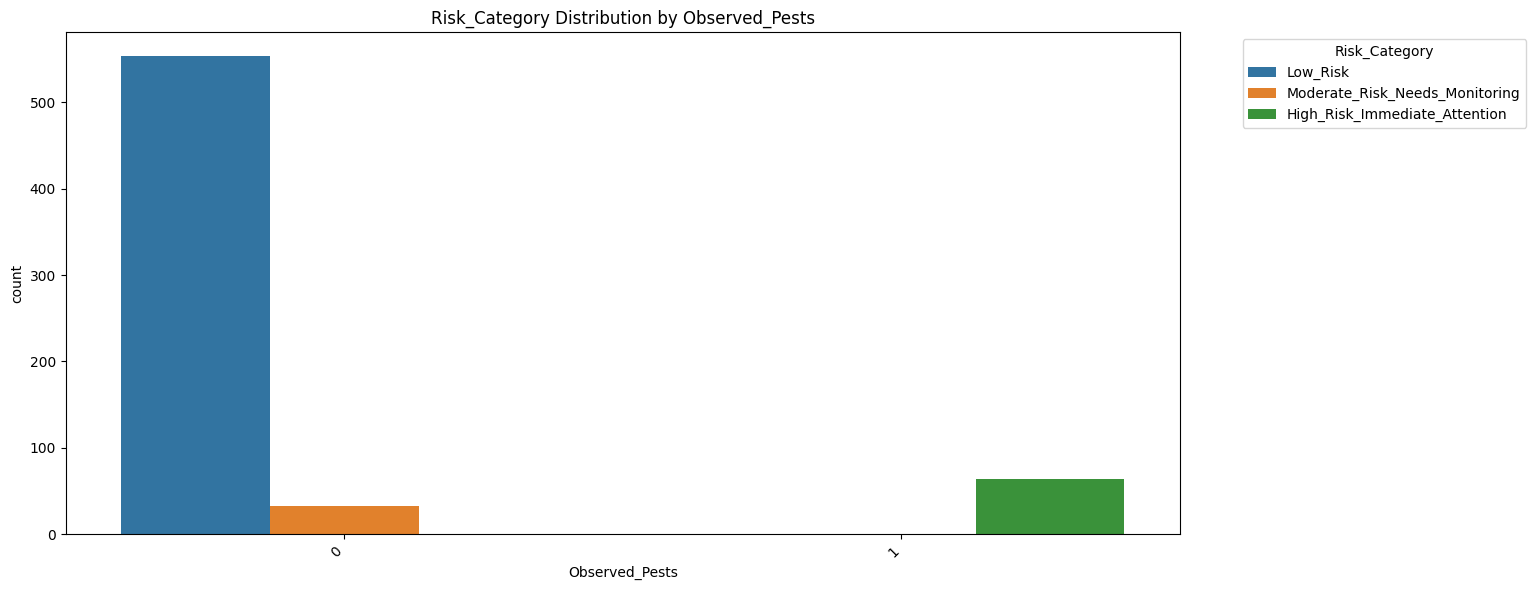


--- Correlation Matrix for Numerical Features (including regression target) ---


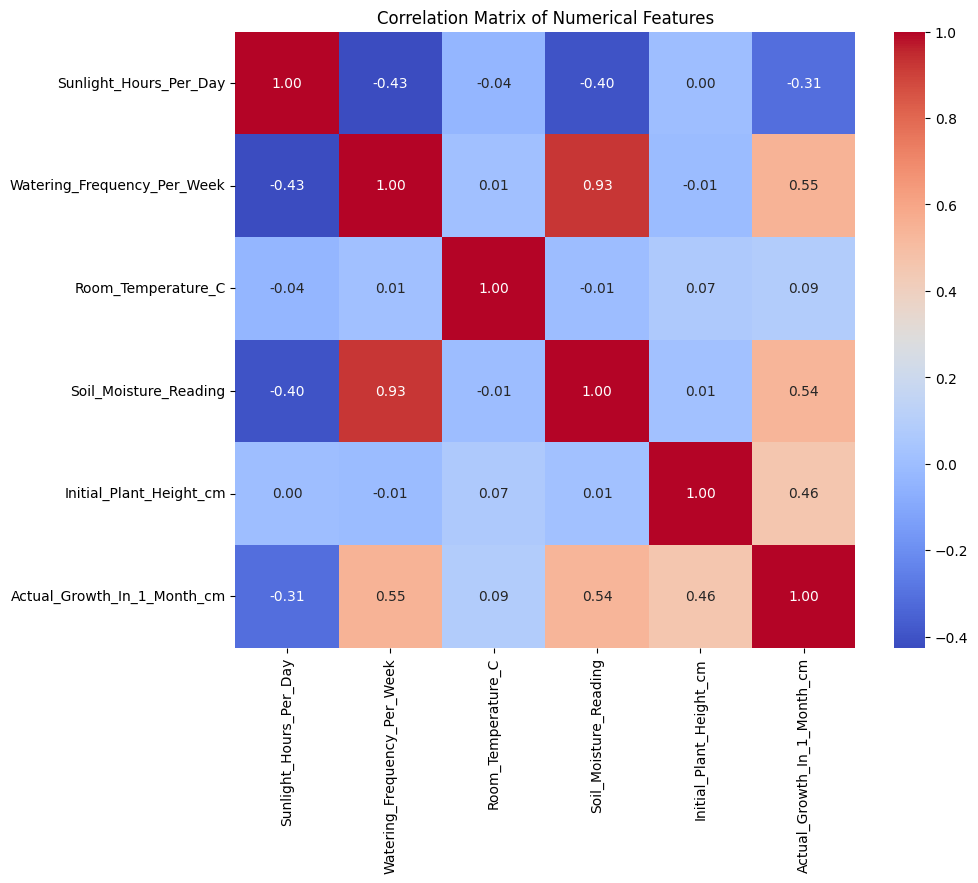


--- Check for Missing Values ---
Plant_ID                       0
Plant_Type                     0
Sunlight_Hours_Per_Day         0
Watering_Frequency_Per_Week    0
Room_Temperature_C             0
Fertilizer_Used                0
Soil_Moisture_Reading          0
Leaf_Appearance                0
Observed_Pests                 0
Initial_Plant_Height_cm        0
Actual_Growth_In_1_Month_cm    0
Risk_Category                  0
dtype: int64


In [ ]:
# Ensure these libraries are imported
import matplotlib.pyplot as plt
import seaborn as sns

# --- I. Exploratory Data Analysis (EDA) ---

print("--- Basic Info & Descriptive Stats ---")
# We already saw df.info() and df.head()
print("\nNumerical Features Description:")
print(df.describe())
print("\nCategorical Features Description:")
print(df.describe(include='object')) # Or include=['category'] if you converted them

print("\n--- Distribution of Key Numerical Features ---")
numerical_features_to_plot = ['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week',
                              'Room_Temperature_C', 'Soil_Moisture_Reading',
                              'Initial_Plant_Height_cm', 'Actual_Growth_In_1_Month_cm']
for col in numerical_features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

print("\n--- Distribution of Categorical Features ---")
categorical_features_to_plot = ['Plant_Type', 'Leaf_Appearance', 'Fertilizer_Used',
                                'Observed_Pests', 'Risk_Category']
for col in categorical_features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[col], order = df[col].value_counts().index) # y for horizontal bars if many categories
    plt.title(f'Distribution of {col}')
    plt.show()

print("\n--- Relationships: Numerical Features vs. Regression Target (Actual_Growth_In_1_Month_cm) ---")
numerical_inputs = ['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week',
                    'Room_Temperature_C', 'Soil_Moisture_Reading', 'Initial_Plant_Height_cm']
regression_target = 'Actual_Growth_In_1_Month_cm'

for col in numerical_inputs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[col], y=df[regression_target])
    plt.title(f'{regression_target} vs. {col}')
    plt.show()

print("\n--- Relationships: Categorical Features vs. Regression Target (Actual_Growth_In_1_Month_cm) ---")
categorical_inputs_for_growth = ['Plant_Type', 'Fertilizer_Used', 'Leaf_Appearance']
for col in categorical_inputs_for_growth:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col], y=df[regression_target])
    plt.title(f'{regression_target} by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\n--- Relationships: Numerical Features vs. Classification Target (Risk_Category) ---")
classification_target = 'Risk_Category'
# Order for risk categories for better visualization
risk_order = ['Low_Risk', 'Moderate_Risk_Needs_Monitoring', 'High_Risk_Immediate_Attention']

for col in numerical_inputs: # Using the same numerical_inputs as before
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[classification_target], y=df[col], order=risk_order)
    plt.title(f'{col} by {classification_target}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


print("\n--- Relationships: Categorical Features vs. Classification Target (Risk_Category) ---")
categorical_inputs_for_risk = ['Plant_Type', 'Leaf_Appearance', 'Fertilizer_Used', 'Observed_Pests']
for col in categorical_inputs_for_risk:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, hue=classification_target, hue_order=risk_order)
    plt.title(f'{classification_target} Distribution by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title=classification_target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


print("\n--- Correlation Matrix for Numerical Features (including regression target) ---")
# Select only numerical columns for correlation matrix
numerical_df_for_corr = df[numerical_features_to_plot].copy() # Using the list from earlier histplot section
# If Fertilizer_Used and Observed_Pests (0/1 ints) should be in correlation, add them:
# numerical_df_for_corr = df.select_dtypes(include=np.number).drop(columns=['Plant_ID'])

plt.figure(figsize=(10, 8))
correlation_matrix = numerical_df_for_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("\n--- Check for Missing Values ---")
print(df.isnull().sum())

**Preprocessing Data Set**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Optional, but good practice for more complex scenarios
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported

# Assuming 'df' is your DataFrame from the previous steps

# --- 1. Drop Unnecessary Columns ---
df_processed = df.drop(columns=['Plant_ID'])
print("Dropped 'Plant_ID'. Current columns:", df_processed.columns.tolist())


# --- 2. Define Features (X) and Targets (y) ---
# Regression Target
X_reg = df_processed.drop(columns=['Actual_Growth_In_1_Month_cm', 'Risk_Category']) # Drop both targets for regression features
y_reg = df_processed['Actual_Growth_In_1_Month_cm']

# Classification Target
# For classification, we can still use Actual_Growth_In_1_Month_cm as a feature if we want
# Or decide to exclude it if we think it directly gives away the Risk_Category too easily (it might)
# Let's keep it simple for now and exclude it to avoid direct leakage if Growth strongly predicts Risk.
X_clf = df_processed.drop(columns=['Risk_Category', 'Actual_Growth_In_1_Month_cm'])
y_clf_categorical = df_processed['Risk_Category'] # Keep it categorical for now for LabelEncoding


# --- 3. Identify Categorical and Numerical Features ---
# (Re-identify based on X_reg and X_clf, as they might differ slightly if we make different feature choices)

# For X_reg
categorical_features_reg = X_reg.select_dtypes(include=['object']).columns.tolist()
numerical_features_reg = X_reg.select_dtypes(include=np.number).columns.tolist()

# For X_clf
categorical_features_clf = X_clf.select_dtypes(include=['object']).columns.tolist()
numerical_features_clf = X_clf.select_dtypes(include=np.number).columns.tolist()

print(f"\n--- For Regression Task ---")
print(f"Categorical features for X_reg: {categorical_features_reg}")
print(f"Numerical features for X_reg: {numerical_features_reg}")
print(f"Target y_reg (shape): {y_reg.shape}")


print(f"\n--- For Classification Task ---")
print(f"Categorical features for X_clf: {categorical_features_clf}")
print(f"Numerical features for X_clf: {numerical_features_clf}")
print(f"Target y_clf_categorical (shape): {y_clf_categorical.shape}")


# --- 4. Train-Test Split ---
# We'll do this separately for regression and classification tasks as their X matrices are slightly different

# For Regression
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# For Classification
X_clf_train, X_clf_test, y_clf_train_cat, y_clf_test_cat = train_test_split(
    X_clf, y_clf_categorical, test_size=0.2, random_state=42, stratify=y_clf_categorical # Stratify for classification
)

print(f"\n--- Train-Test Split Shapes ---")
print(f"X_reg_train: {X_reg_train.shape}, X_reg_test: {X_reg_test.shape}")
print(f"y_reg_train: {y_reg_train.shape}, y_reg_test: {y_reg_test.shape}")
print(f"X_clf_train: {X_clf_train.shape}, X_clf_test: {X_clf_test.shape}")
print(f"y_clf_train_cat (before encoding): {y_clf_train_cat.shape}, y_clf_test_cat (before encoding): {y_clf_test_cat.shape}")


# --- 5. Preprocessing Pipelines (One-Hot Encoding for Categoricals, Scaling for Numericals) ---
# We use ColumnTransformer to apply different transformations to different columns.

# Preprocessor for REGRESSION features
# Note: Ensure categorical_features_reg and numerical_features_reg are correct for X_reg
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features_reg), # drop='first' to avoid multicollinearity
        ('scaler', StandardScaler(), numerical_features_reg)
    ],
    remainder='passthrough' # If any columns are not specified, pass them through. Should be none here.
)

# Preprocessor for CLASSIFICATION features
# Note: Ensure categorical_features_clf and numerical_features_clf are correct for X_clf
preprocessor_clf = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features_clf),
        ('scaler', StandardScaler(), numerical_features_clf)
    ],
    remainder='passthrough'
)

# Apply the transformations
# FIT on the training data, TRANSFORM both training and test data

# For Regression
X_reg_train_processed = preprocessor_reg.fit_transform(X_reg_train)
X_reg_test_processed = preprocessor_reg.transform(X_reg_test)

# For Classification
X_clf_train_processed = preprocessor_clf.fit_transform(X_clf_train)
X_clf_test_processed = preprocessor_clf.transform(X_clf_test)

# The output of ColumnTransformer can sometimes be a numpy array, sometimes a sparse matrix.
# For simplicity and inspection, convert to dense array if it's sparse, and then to DataFrame if needed for viewing
# (though models can often handle numpy arrays directly).

# If you want to see the column names after OHE for inspection:
# Get feature names after one-hot encoding for regression
try:
    feature_names_reg_ohe = preprocessor_reg.named_transformers_['onehot'].get_feature_names_out(categorical_features_reg)
    all_feature_names_reg = np.concatenate([feature_names_reg_ohe, numerical_features_reg])
    X_reg_train_processed_df = pd.DataFrame(X_reg_train_processed.toarray() if hasattr(X_reg_train_processed, "toarray") else X_reg_train_processed, columns=all_feature_names_reg)
    X_reg_test_processed_df = pd.DataFrame(X_reg_test_processed.toarray() if hasattr(X_reg_test_processed, "toarray") else X_reg_test_processed, columns=all_feature_names_reg)
    print("\n--- Processed X_reg_train (first 5 rows as DataFrame) ---")
    print(X_reg_train_processed_df.head())
except Exception as e:
    print(f"Could not create DataFrame for X_reg_train_processed: {e}")
    print("X_reg_train_processed shape:", X_reg_train_processed.shape)
    print("X_reg_test_processed shape:", X_reg_test_processed.shape)


# Get feature names after one-hot encoding for classification
try:
    feature_names_clf_ohe = preprocessor_clf.named_transformers_['onehot'].get_feature_names_out(categorical_features_clf)
    all_feature_names_clf = np.concatenate([feature_names_clf_ohe, numerical_features_clf])
    X_clf_train_processed_df = pd.DataFrame(X_clf_train_processed.toarray() if hasattr(X_clf_train_processed, "toarray") else X_clf_train_processed, columns=all_feature_names_clf)
    X_clf_test_processed_df = pd.DataFrame(X_clf_test_processed.toarray() if hasattr(X_clf_test_processed, "toarray") else X_clf_test_processed, columns=all_feature_names_clf)
    print("\n--- Processed X_clf_train (first 5 rows as DataFrame) ---")
    print(X_clf_train_processed_df.head())
except Exception as e:
    print(f"Could not create DataFrame for X_clf_train_processed: {e}")
    print("X_clf_train_processed shape:", X_clf_train_processed.shape)
    print("X_clf_test_processed shape:", X_clf_test_processed.shape)


# --- 6. Encode the Categorical Target Variable (y_clf) ---
label_encoder = LabelEncoder()
y_clf_train_encoded = label_encoder.fit_transform(y_clf_train_cat)
y_clf_test_encoded = label_encoder.transform(y_clf_test_cat)

print("\n--- Encoded Classification Target (y_clf_train_encoded) ---")
print(f"Original categories: {label_encoder.classes_}")
print(f"Encoded y_clf_train_encoded (first 10): {y_clf_train_encoded[:10]}")
print(f"Encoded y_clf_test_encoded (first 10): {y_clf_test_encoded[:10]}")
print(f"y_clf_train_encoded shape: {y_clf_train_encoded.shape}")

print("\nPreprocessing Complete! Data is ready for model training.")

# We now have:
# For Regression: X_reg_train_processed, X_reg_test_processed, y_reg_train, y_reg_test
# For Classification: X_clf_train_processed, X_clf_test_processed, y_clf_train_encoded, y_clf_test_encoded
# KNN will also use one of these processed X sets (likely X_clf_train_processed or a combined version if we were being very thorough, but for simplicity we can reuse X_clf_train_processed).

Dropped 'Plant_ID'. Current columns: ['Plant_Type', 'Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week', 'Room_Temperature_C', 'Fertilizer_Used', 'Soil_Moisture_Reading', 'Leaf_Appearance', 'Observed_Pests', 'Initial_Plant_Height_cm', 'Actual_Growth_In_1_Month_cm', 'Risk_Category']

--- For Regression Task ---
Categorical features for X_reg: ['Plant_Type', 'Leaf_Appearance']
Numerical features for X_reg: ['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week', 'Room_Temperature_C', 'Fertilizer_Used', 'Soil_Moisture_Reading', 'Observed_Pests', 'Initial_Plant_Height_cm']
Target y_reg (shape): (650,)

--- For Classification Task ---
Categorical features for X_clf: ['Plant_Type', 'Leaf_Appearance']
Numerical features for X_clf: ['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week', 'Room_Temperature_C', 'Fertilizer_Used', 'Soil_Moisture_Reading', 'Observed_Pests', 'Initial_Plant_Height_cm']
Target y_clf_categorical (shape): (650,)

--- Train-Test Split Shapes ---
X_reg_train: (520,

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Linear Regression**


Linear Regression Model Trained.

--- Linear Regression Model Evaluation ---
Mean Absolute Error (MAE): 0.5656
Mean Squared Error (MSE): 0.4837
Root Mean Squared Error (RMSE): 0.6955
R-squared (R²): 0.7437


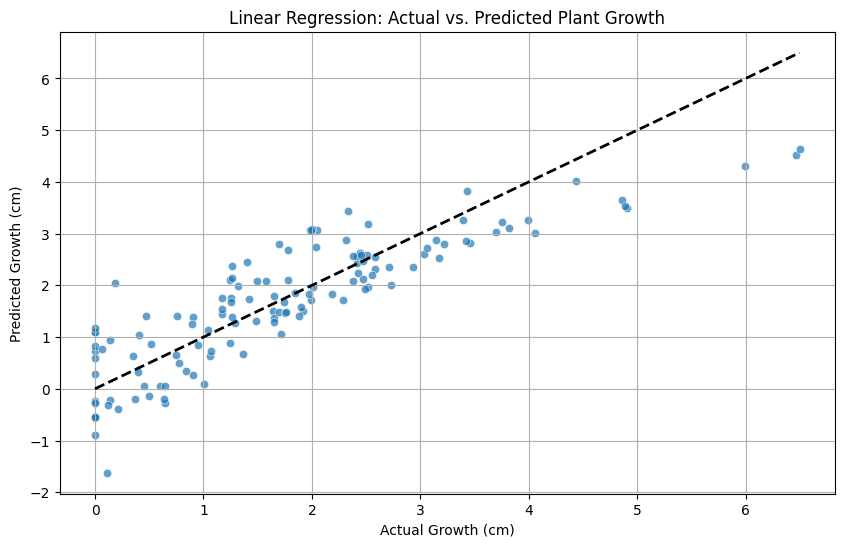

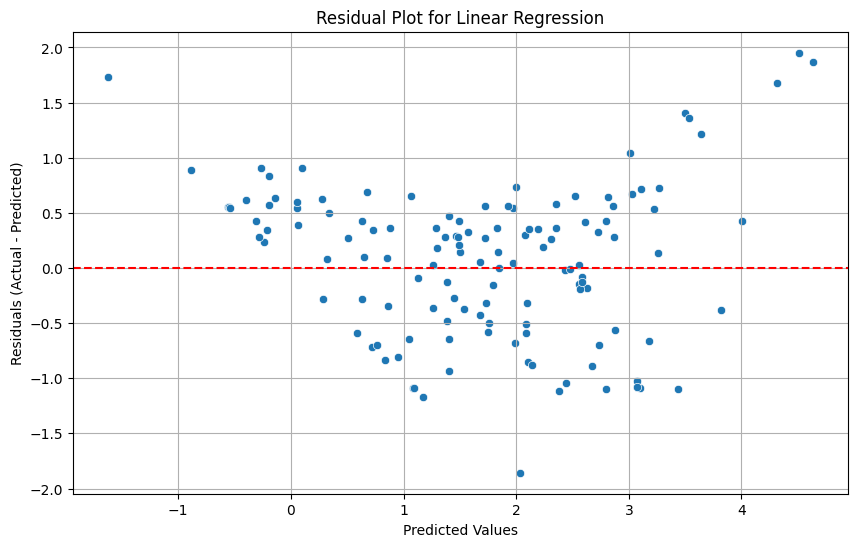


--- Linear Regression Model Coefficients ---
                          Feature  Coefficient
1     Plant_Type_Flowering_Annual     2.631037
2          Plant_Type_Leafy_Green     1.905889
0                 Plant_Type_Fern     1.569467
3            Plant_Type_Succulent     0.650760
14        Initial_Plant_Height_cm     0.642033
4         Leaf_Appearance_Healthy     0.623936
11                Fertilizer_Used     0.219012
6   Leaf_Appearance_Slightly_Pale     0.144099
12          Soil_Moisture_Reading     0.132618
10             Room_Temperature_C     0.045728
7       Leaf_Appearance_Yellowing     0.015860
8          Sunlight_Hours_Per_Day    -0.004271
5     Leaf_Appearance_Pest_Damage    -0.082762
9     Watering_Frequency_Per_Week    -0.172766
13                 Observed_Pests    -0.174852

Intercept: -0.0961


<ipython-input-4-d50b459ba393>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot, palette="vlag")


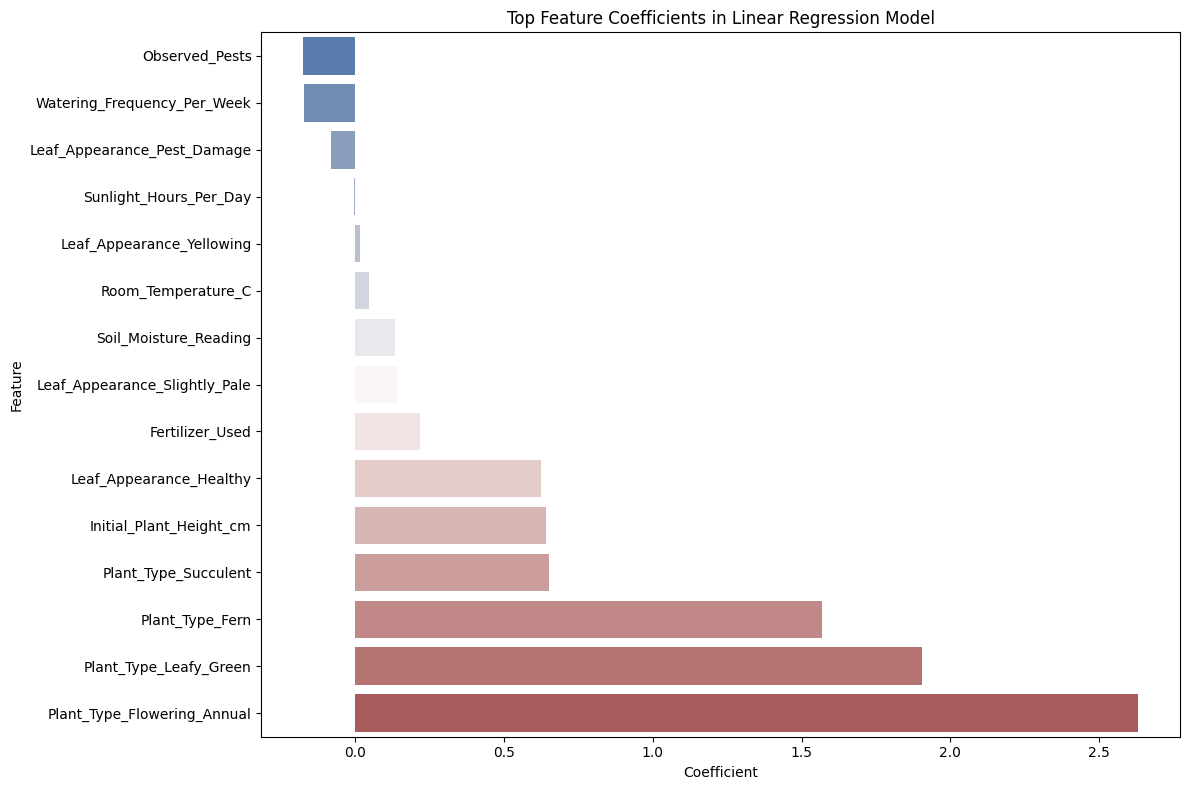

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # for np.sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Initialize and Train the Linear Regression Model ---
# We use the preprocessed regression data: X_reg_train_processed, y_reg_train
lr_model = LinearRegression()
lr_model.fit(X_reg_train_processed, y_reg_train)

print("Linear Regression Model Trained.")

# --- 2. Make Predictions on the Test Set ---
y_reg_pred = lr_model.predict(X_reg_test_processed)

# --- 3. Evaluate the Model ---
mae = mean_absolute_error(y_reg_test, y_reg_pred)
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)

print("\n--- Linear Regression Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Interpretation:
# MAE: Average absolute difference between predicted and actual growth.
# MSE: Average of the squares of the errors. More sensitive to large errors.
# RMSE: Square root of MSE, in the same unit as the target variable (cm). Easier to interpret than MSE.
# R²: Proportion of the variance in the dependent variable that is predictable from the independent variables.
#     Ranges from 0 to 1 (or can be negative for very poor models). Higher is better.

# --- 4. Visualize Predictions vs. Actual Values ---
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel("Actual Growth (cm)")
plt.ylabel("Predicted Growth (cm)")
plt.title("Linear Regression: Actual vs. Predicted Plant Growth")
plt.grid(True)
plt.show()

# Residual Plot (Optional but good for checking assumptions)
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_reg_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Linear Regression')
plt.grid(True)
plt.show()
# Ideal residual plot: points randomly scattered around the horizontal line at 0.
# Patterns (e.g., a curve, a funnel shape) might indicate violations of linear regression assumptions.

# --- 5. (Optional) Inspect Model Coefficients ---
# This requires us to have the feature names from the preprocessor
# If X_reg_train_processed_df was successfully created in the preprocessing step:
if 'all_feature_names_reg' in globals() or 'all_feature_names_reg' in locals():
    try:
        coefficients = pd.DataFrame({
            'Feature': all_feature_names_reg, # Use the feature names obtained after OHE
            'Coefficient': lr_model.coef_
        }).sort_values(by='Coefficient', ascending=False)

        print("\n--- Linear Regression Model Coefficients ---")
        print(coefficients)
        print(f"\nIntercept: {lr_model.intercept_:.4f}")

        # Plotting coefficients for better visualization (top N features)
        plt.figure(figsize=(12, 8))
        # Take top 10 positive and bottom 10 negative (or all if fewer than 20)
        top_n = 10
        coeffs_to_plot = pd.concat([coefficients.head(top_n), coefficients.tail(top_n)]).sort_values(by='Coefficient')
        sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot, palette="vlag")
        plt.title('Top Feature Coefficients in Linear Regression Model')
        plt.tight_layout()
        plt.show()

    except NameError:
        print("\nSkipping coefficient display: 'all_feature_names_reg' not found or X_reg_train_processed_df was not created.")
    except Exception as e:
        print(f"\nCould not display coefficients: {e}")
else:
    print("\nSkipping coefficient display: Feature names array 'all_feature_names_reg' not available.")

**Logistic Regression**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Model Trained.

--- Logistic Regression Model Evaluation ---
Accuracy: 0.9846

Confusion Matrix:


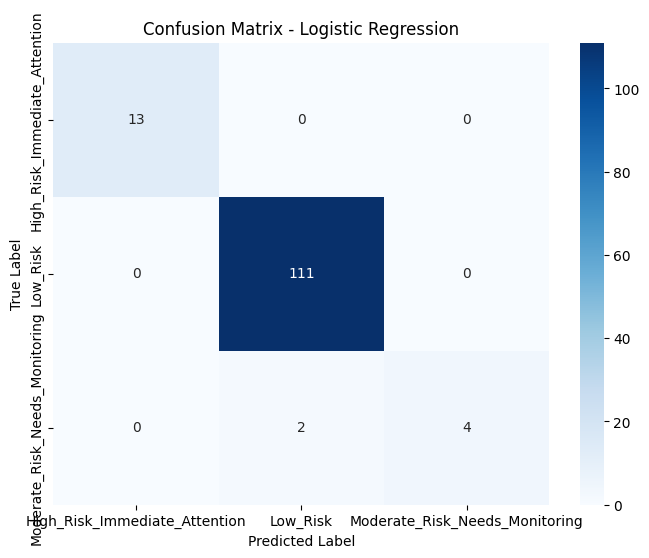


Classification Report:
                                precision    recall  f1-score   support

 High_Risk_Immediate_Attention       1.00      1.00      1.00        13
                      Low_Risk       0.98      1.00      0.99       111
Moderate_Risk_Needs_Monitoring       1.00      0.67      0.80         6

                      accuracy                           0.98       130
                     macro avg       0.99      0.89      0.93       130
                  weighted avg       0.98      0.98      0.98       130


--- Logistic Regression Model Coefficients ---

Coefficients for class: High_Risk_Immediate_Attention (vs Rest)
                        Feature  Coefficient
13               Observed_Pests     2.511691
12        Soil_Moisture_Reading     0.171177
9   Watering_Frequency_Per_Week     0.051919
14      Initial_Plant_Height_cm     0.037238
5   Leaf_Appearance_Pest_Damage     0.006031
11              Fertilizer_Used    -0.002871
10           Room_Temperature_C    -0.026

<ipython-input-5-bd9fef1cd6c6>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot_clf, palette="vlag")


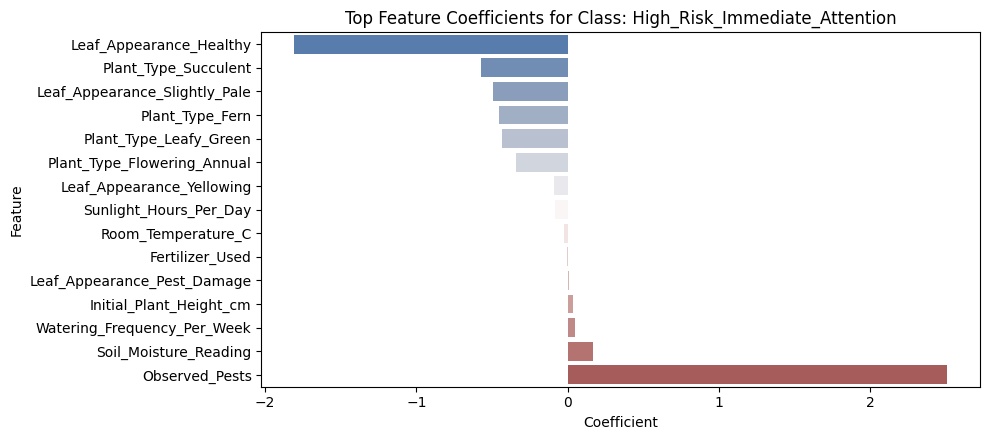


Coefficients for class: Low_Risk (vs Rest)
                          Feature  Coefficient
4         Leaf_Appearance_Healthy     4.455108
6   Leaf_Appearance_Slightly_Pale     1.311523
12          Soil_Moisture_Reading     0.890353
3            Plant_Type_Succulent     0.888576
8          Sunlight_Hours_Per_Day     0.172510
11                Fertilizer_Used     0.159540
10             Room_Temperature_C     0.085380
5     Leaf_Appearance_Pest_Damage    -0.003145
1     Plant_Type_Flowering_Annual    -0.011797
14        Initial_Plant_Height_cm    -0.018008
Intercept for class Low_Risk: -0.2095


<ipython-input-5-bd9fef1cd6c6>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot_clf, palette="vlag")


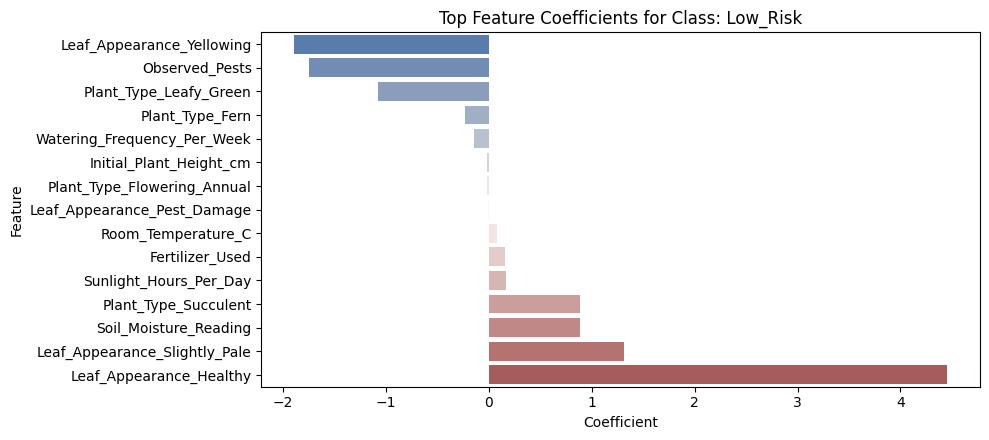


Coefficients for class: Moderate_Risk_Needs_Monitoring (vs Rest)
                        Feature  Coefficient
7     Leaf_Appearance_Yellowing     1.632283
2        Plant_Type_Leafy_Green     0.974789
9   Watering_Frequency_Per_Week     0.146753
0               Plant_Type_Fern     0.122459
14      Initial_Plant_Height_cm     0.021646
5   Leaf_Appearance_Pest_Damage    -0.005574
10           Room_Temperature_C    -0.104503
11              Fertilizer_Used    -0.154213
8        Sunlight_Hours_Per_Day    -0.195808
1   Plant_Type_Flowering_Annual    -0.245747
Intercept for class Moderate_Risk_Needs_Monitoring: -0.7338


<ipython-input-5-bd9fef1cd6c6>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot_clf, palette="vlag")


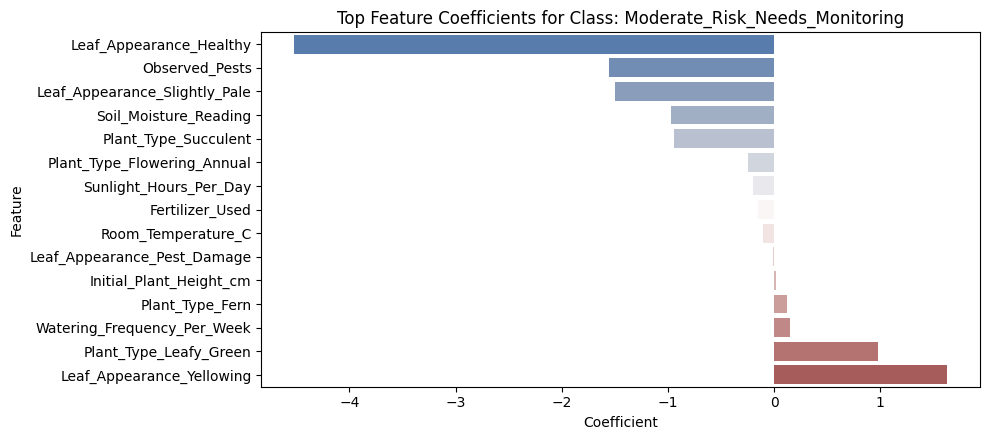

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns # for plotting confusion matrix heatmap
import pandas as pd # To display coefficients if needed
import numpy as np # Ensure numpy is imported

# --- 1. Initialize and Train the Logistic Regression Model ---
# We use the preprocessed classification data: X_clf_train_processed, y_clf_train_encoded
# 'multi_class="ovr"' (One-vs-Rest) is a common strategy for multiclass classification.
# 'solver="liblinear"' is a good default for smaller datasets and works well with L1/L2 regularization.
# Increase max_iter if it doesn't converge, common with scaled data.
log_reg_model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, max_iter=1000)
log_reg_model.fit(X_clf_train_processed, y_clf_train_encoded)

print("Logistic Regression Model Trained.")

# --- 2. Make Predictions on the Test Set ---
y_clf_pred_encoded = log_reg_model.predict(X_clf_test_processed)

# If you want to see the actual category names instead of encoded labels for prediction:
# y_clf_pred_labels = label_encoder.inverse_transform(y_clf_pred_encoded)
# print("\nSample Predicted Risk Categories (first 10):")
# print(y_clf_pred_labels[:10])

# --- 3. Evaluate the Model ---
accuracy = accuracy_score(y_clf_test_encoded, y_clf_pred_encoded)

print("\n--- Logistic Regression Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_clf_test_encoded, y_clf_pred_encoded)
# To see it with labels:
# cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
# cmd.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Logistic Regression')
# plt.show()

# More visually appealing Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


# Classification Report
print("\nClassification Report:")
# Use target_names to show actual class names in the report
report = classification_report(y_clf_test_encoded, y_clf_pred_encoded, target_names=label_encoder.classes_)
print(report)

# Interpretation of Classification Report:
# - Precision: TP / (TP + FP) - Of all instances predicted as a certain class, how many were correct?
# - Recall (Sensitivity): TP / (TP + FN) - Of all actual instances of a class, how many did we correctly predict?
# - F1-score: Harmonic mean of precision and recall. Good for imbalanced classes.
# - Support: Number of actual instances of the class in the test set.

# --- 4. (Optional) Inspect Model Coefficients (for Logistic Regression) ---
# This works because Logistic Regression is a linear model.
# For multi_class='ovr', it trains one classifier per class.
# Coefficients will be an array of shape (n_classes, n_features)
if 'all_feature_names_clf' in globals() or 'all_feature_names_clf' in locals():
    try:
        print("\n--- Logistic Regression Model Coefficients ---")
        # Iterate through each class and print its coefficients
        for i, class_label in enumerate(label_encoder.classes_):
            print(f"\nCoefficients for class: {class_label} (vs Rest)")
            coefficients = pd.DataFrame({
                'Feature': all_feature_names_clf, # Feature names from OHE in preprocessing
                'Coefficient': log_reg_model.coef_[i] # coef_[i] for the i-th class
            }).sort_values(by='Coefficient', ascending=False)
            print(coefficients.head(10)) # Display top 10 influential features for this class
            print(f"Intercept for class {class_label}: {log_reg_model.intercept_[i]:.4f}")

            # Simple bar plot for the current class's coefficients
            plt.figure(figsize=(10, min(6, len(coefficients)*0.3))) # Adjust height
            top_n_coeffs_clf = 10
            coeffs_to_plot_clf = pd.concat([coefficients.head(top_n_coeffs_clf), coefficients.tail(top_n_coeffs_clf)]).sort_values(by='Coefficient')

            sns.barplot(x='Coefficient', y='Feature', data=coeffs_to_plot_clf, palette="vlag")
            plt.title(f'Top Feature Coefficients for Class: {class_label}')
            plt.tight_layout()
            plt.show()
    except NameError:
        print("\nSkipping coefficient display: 'all_feature_names_clf' not found or X_clf_train_processed_df was not created.")
    except Exception as e:
        print(f"\nCould not display coefficients: {e}")
else:
    print("\nSkipping coefficient display: Feature names array 'all_feature_names_clf' not available.")

**KNN**

--- Part 1: KNN as a Classifier ---
KNN Classifier (k=5) Trained.

--- KNN Classifier Evaluation ---
Accuracy (k=5): 0.9615

Confusion Matrix (KNN):


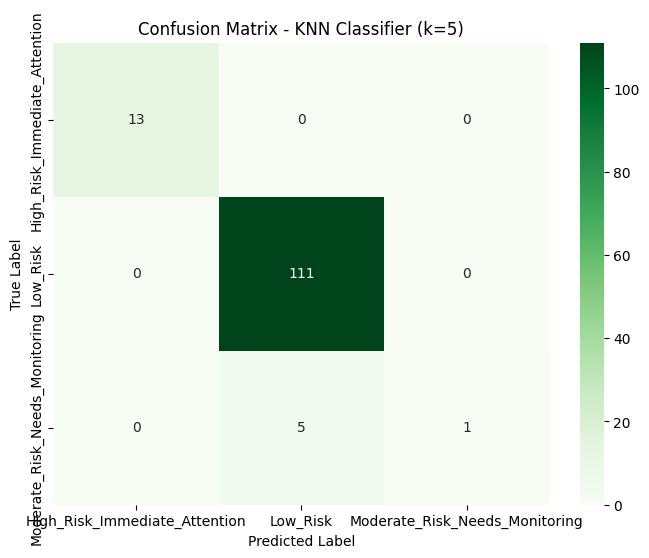


Classification Report (KNN):
                                precision    recall  f1-score   support

 High_Risk_Immediate_Attention       1.00      1.00      1.00        13
                      Low_Risk       0.96      1.00      0.98       111
Moderate_Risk_Needs_Monitoring       1.00      0.17      0.29         6

                      accuracy                           0.96       130
                     macro avg       0.99      0.72      0.75       130
                  weighted avg       0.96      0.96      0.95       130



--- Part 2: KNN for Finding Similar Plants (Recommendation) ---
NearestNeighbors model fitted on X_clf_train_processed to find 5 neighbors.

Hypothetical plant data (before processing):
  Plant_Type  Sunlight_Hours_Per_Day  Watering_Frequency_Per_Week  \
0       Fern                     3.0                          2.5   

   Room_Temperature_C  Fertilizer_Used  Soil_Moisture_Reading Leaf_Appearance  \
0                22.0                0                 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Part 1: KNN as a Classifier ---
print("--- Part 1: KNN as a Classifier ---")

# --- 1a. Initialize and Train the KNN Classifier ---
# We need to choose a value for 'k' (n_neighbors). A common starting point is sqrt(N_train), or often 3, 5, 7.
# Let's try k=5 as a start.
k_value = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k_value)
knn_classifier.fit(X_clf_train_processed, y_clf_train_encoded)

print(f"KNN Classifier (k={k_value}) Trained.")

# --- 1b. Make Predictions on the Test Set ---
y_knn_pred_encoded = knn_classifier.predict(X_clf_test_processed)

# --- 1c. Evaluate the KNN Classifier ---
knn_accuracy = accuracy_score(y_clf_test_encoded, y_knn_pred_encoded)

print("\n--- KNN Classifier Evaluation ---")
print(f"Accuracy (k={k_value}): {knn_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (KNN):")
knn_cm = confusion_matrix(y_clf_test_encoded, y_knn_pred_encoded)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - KNN Classifier (k={k_value})')
plt.show()

# Classification Report
print("\nClassification Report (KNN):")
knn_report = classification_report(y_clf_test_encoded, y_knn_pred_encoded, target_names=label_encoder.classes_)
print(knn_report)

# Note: Finding the optimal 'k' often involves techniques like cross-validation,
# but for this basic project, we'll just pick a common value.

# --- Part 2: KNN for Finding Similar Plants (Recommendation Aspect) ---
print("\n\n--- Part 2: KNN for Finding Similar Plants (Recommendation) ---")

# We'll use the `NearestNeighbors` utility from scikit-learn for this.
# It doesn't predict a class, but rather finds the neighbors.
# We will fit it on the full processed training feature set (X_clf_train_processed).
# The 'y' (target) isn't directly used by NearestNeighbors for fitting, only for looking up later.
n_recommendations = 5 # Number of similar plants to find
nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='minkowski') # minkowski is default, p=2 for Euclidean
nn_model.fit(X_clf_train_processed)

print(f"NearestNeighbors model fitted on X_clf_train_processed to find {n_recommendations} neighbors.")

# Let's create a hypothetical new plant scenario that a user might input.
# This scenario needs to be preprocessed in the EXACT SAME WAY as our training data.
#
# Hypothetical scenario:
# Plant_Type: 'Fern'
# Sunlight_Hours_Per_Day: 3
# Watering_Frequency_Per_Week: 2.5
# Room_Temperature_C: 22
# Fertilizer_Used: 0 (No)
# Soil_Moisture_Reading: 4
# Leaf_Appearance: 'Yellowing'
# Observed_Pests: 0 (No)
# Initial_Plant_Height_cm: 15 (though this was in X_reg, let's assume it's a feature in X_clf if it's in numerical_features_clf)
# If Initial_Plant_Height_cm is not in X_clf features, exclude it here too.

# Reconstruct the order of features for the hypothetical plant as expected by preprocessor_clf
# Use `X_clf_train.columns` to ensure correct order and feature set for the new plant data.

hypothetical_plant_data = {} # This dictionary will hold our hypothetical plant's features

# Get the column order from X_clf_train (before OHE and scaling)
original_feature_order_clf = X_clf_train.columns.tolist() # From Preprocessing cell

# Fill with example values
hypothetical_plant_data['Plant_Type'] = 'Fern'
hypothetical_plant_data['Sunlight_Hours_Per_Day'] = 3.0
hypothetical_plant_data['Watering_Frequency_Per_Week'] = 2.5
hypothetical_plant_data['Room_Temperature_C'] = 22.0
hypothetical_plant_data['Fertilizer_Used'] = 0 # Already numerical 0/1
hypothetical_plant_data['Soil_Moisture_Reading'] = 4.0
hypothetical_plant_data['Leaf_Appearance'] = 'Yellowing' # Will be one-hot encoded
hypothetical_plant_data['Observed_Pests'] = 0 # Already numerical 0/1

# Add any other numerical features that were part of X_clf:
if 'Initial_Plant_Height_cm' in original_feature_order_clf:
    hypothetical_plant_data['Initial_Plant_Height_cm'] = 15.0
# Ensure all features expected by X_clf_train are present. Add defaults if any are missing.
for col in original_feature_order_clf:
    if col not in hypothetical_plant_data:
        if df_processed[col].dtype == 'object': # from original df_processed
            hypothetical_plant_data[col] = df_processed[col].mode()[0] # Use mode for missing categorical
        else:
            hypothetical_plant_data[col] = df_processed[col].median() # Use median for missing numerical
        print(f"Warning: Missing feature '{col}' in hypothetical data, using default: {hypothetical_plant_data[col]}")


# Create a DataFrame with the correct column order for the preprocessor
hypothetical_plant_df = pd.DataFrame([hypothetical_plant_data], columns=original_feature_order_clf)
print("\nHypothetical plant data (before processing):")
print(hypothetical_plant_df)

# Now, preprocess this hypothetical plant data using the *already fitted* preprocessor_clf
try:
    hypothetical_plant_processed = preprocessor_clf.transform(hypothetical_plant_df)
    print("\nHypothetical plant data (after processing, ready for KNN):")
    # print(hypothetical_plant_processed) # This will be a NumPy array
    print("Shape:", hypothetical_plant_processed.shape)


    # Find the nearest neighbors in the training set
    distances, indices = nn_model.kneighbors(hypothetical_plant_processed)

    print(f"\n--- Top {n_recommendations} Similar Plants from Training Data ---")
    print(f"Distances to neighbors: {distances[0]}") # distances for the first (and only) hypothetical plant
    print(f"Indices of neighbors in X_clf_train: {indices[0]}") # indices for the first hypothetical plant

    # Retrieve the details of these neighbors from the original training data (X_clf_train and y_clf_train_cat)
    # before it was heavily processed (but after initial cleaning/selection)
    # Use X_clf_train and y_clf_train_cat from the preprocessing step

    similar_plants_df = X_clf_train.iloc[indices[0]].copy() # Get original features of neighbors
    similar_plants_df['Risk_Category (Actual)'] = y_clf_train_cat.iloc[indices[0]].values # Add their actual risk category

    print("\nDetails of Similar Plants:")
    print(similar_plants_df)

    # --- How to use this for recommendation: ---
    # 1. Plant Type Recommendation: If user is looking for a NEW plant, they input desired conditions.
    #    KNN finds existing plants thriving (e.g., Low_Risk) under those conditions.
    #    Then recommend the Plant_Type of those neighbors.
    #
    # 2. Care Adjustment Recommendation: If user has a struggling plant (like our hypothetical 'Fern').
    #    Look at the 'similar_plants_df'.
    #    - Are many of them "Low_Risk"? If so, what were their `Watering_Frequency_Per_Week`, `Sunlight_Hours_Per_Day`?
    #      This could suggest adjustments.
    #    - If we had a column like "Care_Action_That_Helped" in our original data (we don't in this synthetic set),
    #      we could look at that for the neighbors.
    print("\nExample Recommendation Logic for a struggling 'Fern':")
    low_risk_neighbors = similar_plants_df[similar_plants_df['Risk_Category (Actual)'] == 'Low_Risk']
    if not low_risk_neighbors.empty:
        print(f"\nFound {len(low_risk_neighbors)} similar 'Low_Risk' plants. Their average care was:")
        # We can calculate average conditions of these successful neighbors.
        # This needs original (non-scaled) numerical features for better interpretation.
        # We'd need to map back from processed space or retrieve from a pre-scaled dataframe for just these indices.
        # For simplicity, we're showing their data as is from X_clf_train.
        print(low_risk_neighbors[['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week', 'Soil_Moisture_Reading']].mean())
        print("Consider adjusting care towards these values if significantly different.")
    else:
        print("\nNo similar 'Low_Risk' plants found among the direct neighbors. Further analysis needed or broader search.")

except Exception as e:
    print(f"\nError during KNN recommendation part: {e}")
    print("Ensure 'preprocessor_clf', 'X_clf_train', and 'y_clf_train_cat' are available and correctly defined from the preprocessing step.")

In [ ]:
# Cell: ## 6. Algorithm 3: K-Nearest Neighbors (KNN)

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Part 1: KNN as a Classifier ---
print("--- Part 1: KNN as a Classifier ---")

# Ensure necessary variables like X_clf_train_processed, y_clf_train_encoded,
# X_clf_test_processed, y_clf_test_encoded, label_encoder are available from previous cells.
if 'X_clf_train_processed' not in locals() or 'y_clf_train_encoded' not in locals():
    print("Error: KNN Classifier part needs X_clf_train_processed and y_clf_train_encoded. Run preprocessing.")
else:
    k_value = 5
    knn_classifier = KNeighborsClassifier(n_neighbors=k_value)
    knn_classifier.fit(X_clf_train_processed, y_clf_train_encoded)
    print(f"KNN Classifier (k={k_value}) Trained.")

    y_knn_pred_encoded = knn_classifier.predict(X_clf_test_processed) # Assuming X_clf_test_processed is available
    knn_accuracy = accuracy_score(y_clf_test_encoded, y_knn_pred_encoded) # Assuming y_clf_test_encoded is available

    print("\n--- KNN Classifier Evaluation ---")
    print(f"Accuracy (k={k_value}): {knn_accuracy:.4f}")

    knn_cm = confusion_matrix(y_clf_test_encoded, y_knn_pred_encoded)
    plt.figure(figsize=(8, 6))
    sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_) # Assuming label_encoder is available
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - KNN Classifier (k={k_value})')
    plt.show()

    print("\nClassification Report (KNN):")
    knn_report = classification_report(y_clf_test_encoded, y_knn_pred_encoded, target_names=label_encoder.classes_)
    print(knn_report)


# --- Part 2: KNN for Finding Similar Plants (Recommendation with User Input) ---
print("\n\n--- Part 2: KNN for Finding Similar Plants (Recommendation with User Input) ---")

# Ensure nn_model related variables are correctly managed or re-initialized
# and preprocessor_clf, X_clf_train, df_processed, y_clf_train_cat are available.

if 'X_clf_train_processed' not in locals():
    print("Error: KNN Recommendation part needs X_clf_train_processed. Run preprocessing.")
else:
    n_recommendations = 5
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='minkowski')
    nn_model.fit(X_clf_train_processed)
    print(f"NearestNeighbors model fitted on X_clf_train_processed to find {n_recommendations} neighbors.")

    print("\n--- Enter Details for Your Plant Scenario (for KNN Recommendation) ---")

    if 'X_clf_train' not in locals() or 'df_processed' not in locals():
        print("ERROR: X_clf_train or df_processed is not defined. Please run earlier cells.")
    else:
        original_feature_order_clf = X_clf_train.columns.tolist()
        hypothetical_plant_data_knn = {} # Use a distinct name for clarity

        print(f"Available Plant Types: {df_processed['Plant_Type'].unique().tolist()}")
        while True:
            pt = input(f"Enter Plant_Type for KNN (e.g., Fern): ")
            if pt in df_processed['Plant_Type'].unique():
                hypothetical_plant_data_knn['Plant_Type'] = pt
                break
            print("Invalid plant type. Please choose from the list.")

        hypothetical_plant_data_knn['Sunlight_Hours_Per_Day'] = float(input("Enter Sunlight_Hours_Per_Day for KNN (e.g., 3.0): "))
        hypothetical_plant_data_knn['Watering_Frequency_Per_Week'] = float(input("Enter Watering_Frequency_Per_Week for KNN (e.g., 2.5): "))
        hypothetical_plant_data_knn['Room_Temperature_C'] = float(input("Enter Room_Temperature_C for KNN (e.g., 22.0): "))
        hypothetical_plant_data_knn['Fertilizer_Used'] = int(input("Fertilizer_Used for KNN? (0 for No, 1 for Yes): "))

        print(f"Available Leaf Appearances: {df_processed['Leaf_Appearance'].unique().tolist()}")
        while True:
            la = input(f"Enter Leaf_Appearance for KNN (e.g., Yellowing): ")
            if la in df_processed['Leaf_Appearance'].unique():
                hypothetical_plant_data_knn['Leaf_Appearance'] = la
                break
            print("Invalid leaf appearance. Please choose from the list.")

        hypothetical_plant_data_knn['Observed_Pests'] = int(input("Observed_Pests for KNN? (0 for No, 1 for Yes): "))
        hypothetical_plant_data_knn['Soil_Moisture_Reading'] = float(input("Enter Soil_Moisture_Reading for KNN (1-10, e.g., 4.0): "))

        if 'Initial_Plant_Height_cm' in original_feature_order_clf: # Check if this feature is used by X_clf
            hypothetical_plant_data_knn['Initial_Plant_Height_cm'] = float(input("Enter Initial_Plant_Height_cm for KNN (e.g., 15.0): "))

        for col in original_feature_order_clf:
            if col not in hypothetical_plant_data_knn:
                print(f"Warning (KNN): Feature '{col}' was not explicitly asked for.")
                if df_processed[col].dtype == 'object': hypothetical_plant_data_knn[col] = df_processed[col].mode()[0]
                else: hypothetical_plant_data_knn[col] = df_processed[col].median()
                print(f"Using default value for {col}: {hypothetical_plant_data_knn[col]}")

        hypothetical_plant_df_knn = pd.DataFrame([hypothetical_plant_data_knn], columns=original_feature_order_clf)
        print("\nUser's plant data for KNN (before processing):")
        print(hypothetical_plant_df_knn)

        try:
            if 'preprocessor_clf' not in locals(): print("ERROR: preprocessor_clf is not defined.")
            else:
                processed_input_for_knn = preprocessor_clf.transform(hypothetical_plant_df_knn)
                distances, indices = nn_model.kneighbors(processed_input_for_knn)
                print(f"\n--- Top {n_recommendations} Similar Plants (KNN Recommendation) ---")
                # ... (rest of the recommendation display logic from previous answer) ...
                if 'X_clf_train' not in locals() or 'y_clf_train_cat' not in locals():
                    print("ERROR: X_clf_train or y_clf_train_cat not available for neighbor lookup.")
                else:
                    similar_plants_df = X_clf_train.iloc[indices[0]].copy()
                    similar_plants_df['Risk_Category (Actual)'] = y_clf_train_cat.iloc[indices[0]].values
                    print("\nDetails of Similar Plants:")
                    print(similar_plants_df)

                    # Recommendation Logic
                    print("\nExample Recommendation Logic based on KNN similar plants:")
                    low_risk_neighbors = similar_plants_df[similar_plants_df['Risk_Category (Actual)'] == 'Low_Risk']
                    if not low_risk_neighbors.empty:
                        print(f"\nFound {len(low_risk_neighbors)} similar 'Low_Risk' plants. Their average care was:")
                        # Note: These features are from X_clf_train, so they are original scale if they were numerical.
                        # If they were part of one-hot encoding, they won't be directly interpretable here.
                        # Focus on original numerical features for average care.
                        display_cols_avg_care = [col for col in ['Sunlight_Hours_Per_Day', 'Watering_Frequency_Per_Week', 'Soil_Moisture_Reading'] if col in low_risk_neighbors.columns]
                        if display_cols_avg_care:
                             print(low_risk_neighbors[display_cols_avg_care].mean(numeric_only=True))
                        else:
                             print("No suitable numerical care features found in similar low-risk plants for averaging.")
                        print("Consider adjusting your care towards these values if significantly different.")
                    else:
                        print("\nNo directly similar 'Low_Risk' plants found among the immediate neighbors via KNN.")


        except Exception as e:
            print(f"\nError during KNN recommendation part with user input: {e}")
            import traceback
            traceback.print_exc()

--- Part 1: KNN as a Classifier ---
Error: KNN Classifier part needs X_clf_train_processed and y_clf_train_encoded. Run preprocessing.


--- Part 2: KNN for Finding Similar Plants (Recommendation with User Input) ---
Error: KNN Recommendation part needs X_clf_train_processed. Run preprocessing.
